In [1]:
# Required imports
import os.path
from typing import Dict, Tuple, Optional
import torch as th
import numpy as np
import itertools

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations, FourthOrderEquations, simpson_integral
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [5]:
class PendulumChapter(SystemEquations):
    """
    Physics-informed NN for the simple pendulum x'' + sin(x) = 0,
    usingboth an action integral and a residual penalty.
    """
    def __init__(self, functions, domain, initial_conditions, *, coeffs: tuple[float, float, float] = (1.0, 1.0, 1.0)):
        super().__init__(functions, domain, initial_conditions)
        a, b, c = coeffs
        self.coeffs = {"action": a, "dynamics": b, "hamiltonian": c}

    def configuration(self):
        cfg = super().configuration()
        cfg["coefficients"] = self.coeffs
        return cfg

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:

        real = self.calculate_trial_solution(inputs, outputs)
        
        # 2) their time-derivatives
        deriv = {
            fn: compute_derivative(inputs, val)
            for fn, val in real.items()
        }
        
        # 3) residual penalties enforcing x' = y and y' = −sin(x)
        mse_d = th.nn.MSELoss(reduction='sum')
        pen1 = mse_d(deriv["x"], real["y"])
        pen2 = mse_d(deriv["y"], -th.sin(real["x"]))
        mse_dynamics = pen1 + pen2

        mse_h = th.nn.MSELoss(reduction='sum')
        H = 0.5 * real["y"]**2 + (1.0 - th.cos(real["x"]))
        x0 = real["x"][0]
        y0 = real["y"][0]
        H0 = 0.5 * y0**2 + (1.0 - th.cos(x0))
        H0_t = H.new_ones(H.shape) * H0
        mse_hamiltonian = mse_h(H, H0_t)
        
        
        # 4) pendulum Lagrangian L = ½ y² − (1 − cos x)
        L = 0.5 * real["y"]**2 - (1.0 - th.cos(real["x"]))
        action = th.trapz(L.view(-1), inputs.view(-1))
        #action = simpson_integral(L.view(-1), inputs.view(-1))
        
        # 5) combine (you can tune a,b if you like)
        a, b, c = self.coeffs["action"], self.coeffs["dynamics"], self.coeffs["hamiltonian"]
        total = a*action + b*mse_dynamics + c*mse_hamiltonian

        return {"total": total, "dynamics": mse_dynamics, "hamiltonian": mse_hamiltonian}

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -np.sin(x)
        return [dxdt, dydt]

  0%|                                       | 1/40000 [00:00<5:07:25,  2.17it/s]

122839.42763084847


  0%|                                     | 101/40000 [00:13<1:29:56,  7.39it/s]

7976.637545530168


  1%|▏                                    | 201/40000 [00:27<1:28:01,  7.53it/s]

6839.5948742985265


  1%|▎                                    | 301/40000 [00:41<1:26:45,  7.63it/s]

5548.854786306849


  1%|▎                                    | 401/40000 [00:54<1:28:51,  7.43it/s]

5191.198906679825


  1%|▍                                    | 501/40000 [01:08<1:29:36,  7.35it/s]

3296.2702400291028


  2%|▌                                    | 601/40000 [01:22<1:34:25,  6.95it/s]

3514.781528104097


  2%|▋                                    | 701/40000 [01:36<1:26:31,  7.57it/s]

3115.063287550183


  2%|▋                                    | 801/40000 [01:49<1:29:28,  7.30it/s]

2830.057586070364


  2%|▊                                    | 901/40000 [02:03<1:26:38,  7.52it/s]

3472.2502356381324


  3%|▉                                   | 1001/40000 [02:16<1:27:45,  7.41it/s]

2661.572217775357


  3%|▉                                   | 1101/40000 [02:30<1:24:32,  7.67it/s]

2610.8839004221427


  3%|█                                   | 1201/40000 [02:43<1:29:05,  7.26it/s]

3159.989417527845


  3%|█▏                                  | 1301/40000 [02:56<1:24:42,  7.61it/s]

2665.6837861628983


  4%|█▎                                  | 1401/40000 [03:10<1:32:26,  6.96it/s]

2746.73398734079


  4%|█▎                                  | 1501/40000 [03:23<1:25:30,  7.50it/s]

2873.9715957775297


  4%|█▍                                  | 1601/40000 [03:37<1:24:38,  7.56it/s]

2404.1107689822516


  4%|█▌                                  | 1701/40000 [03:50<1:24:34,  7.55it/s]

2509.8592505294164


  5%|█▌                                  | 1801/40000 [04:04<1:29:20,  7.13it/s]

3732.8045066076584


  5%|█▋                                  | 1901/40000 [04:17<1:23:43,  7.58it/s]

2213.2708611301296


  5%|█▊                                  | 2001/40000 [04:30<1:23:19,  7.60it/s]

2143.399616926661


  5%|█▉                                  | 2101/40000 [04:44<1:23:00,  7.61it/s]

2200.3877828043405


  6%|█▉                                  | 2201/40000 [04:57<1:23:41,  7.53it/s]

2276.965230785961


  6%|██                                  | 2301/40000 [05:10<1:23:49,  7.50it/s]

1907.328920471557


  6%|██▏                                 | 2401/40000 [05:24<1:23:37,  7.49it/s]

1845.20493172608


  6%|██▎                                 | 2501/40000 [05:37<1:21:48,  7.64it/s]

1850.9793699454294


  7%|██▎                                 | 2601/40000 [05:50<1:26:04,  7.24it/s]

1786.0075747367769


  7%|██▍                                 | 2701/40000 [06:04<1:22:19,  7.55it/s]

1655.30800254161


  7%|██▌                                 | 2801/40000 [06:17<1:22:46,  7.49it/s]

1807.5937186507745


  7%|██▌                                 | 2901/40000 [06:31<1:23:20,  7.42it/s]

1423.9117630371345


  8%|██▋                                 | 3001/40000 [06:44<1:20:30,  7.66it/s]

1386.3997433739828


  8%|██▊                                 | 3101/40000 [06:57<1:25:13,  7.22it/s]

1877.4760648853048


  8%|██▉                                 | 3201/40000 [07:11<1:23:27,  7.35it/s]

1229.4911635043218


  8%|██▉                                 | 3301/40000 [07:24<1:21:32,  7.50it/s]

1262.6771049372144


  9%|███                                 | 3401/40000 [07:38<1:21:09,  7.52it/s]

1165.5408802780926


  9%|███▏                                | 3501/40000 [07:51<1:19:23,  7.66it/s]

1895.0766595707528


  9%|███▏                                | 3601/40000 [08:04<1:19:27,  7.63it/s]

1199.6698787647451


  9%|███▎                                | 3701/40000 [08:18<1:24:16,  7.18it/s]

1144.0667741118764


 10%|███▍                                | 3801/40000 [08:31<1:22:29,  7.31it/s]

1071.166195473509


 10%|███▌                                | 3901/40000 [08:45<1:18:31,  7.66it/s]

1066.3330908373282


 10%|███▌                                | 4001/40000 [08:58<1:21:07,  7.40it/s]

1371.3483637543152


 10%|███▋                                | 4101/40000 [09:12<1:47:16,  5.58it/s]

1375.789796544586


 11%|███▊                                | 4201/40000 [09:26<1:18:29,  7.60it/s]

698.5439146228115


 11%|███▊                                | 4301/40000 [09:39<1:21:15,  7.32it/s]

468.034120485019


 11%|███▉                                | 4401/40000 [09:53<1:22:52,  7.16it/s]

165.14293302847705


 11%|████                                | 4501/40000 [10:06<1:18:01,  7.58it/s]

152.03384730251526


 12%|████▏                               | 4601/40000 [10:20<1:19:46,  7.40it/s]

126.3228332272544


 12%|████▏                               | 4701/40000 [10:33<1:18:49,  7.46it/s]

113.40529440780381


 12%|████▎                               | 4801/40000 [10:47<1:18:38,  7.46it/s]

142.4029798298207


 12%|████▍                               | 4901/40000 [11:00<1:19:47,  7.33it/s]

102.75821435061563


 13%|████▌                               | 5001/40000 [11:14<1:22:45,  7.05it/s]

79.42427466888569


 13%|████▌                               | 5101/40000 [11:28<1:20:09,  7.26it/s]

71.78643684124745


 13%|████▋                               | 5201/40000 [11:42<1:17:07,  7.52it/s]

130.25721467182245


 13%|████▊                               | 5301/40000 [11:56<1:19:48,  7.25it/s]

602.6872210700765


 14%|████▊                               | 5401/40000 [12:10<1:25:35,  6.74it/s]

57.0238606493152


 14%|████▉                               | 5501/40000 [12:24<1:19:33,  7.23it/s]

60.209454142620984


 14%|█████                               | 5601/40000 [12:38<1:24:25,  6.79it/s]

53.67089187191044


 14%|█████▏                              | 5701/40000 [12:52<1:17:17,  7.40it/s]

49.02647827158145


 15%|█████▏                              | 5801/40000 [13:05<1:23:21,  6.84it/s]

47.61789212392154


 15%|█████▎                              | 5901/40000 [13:19<1:17:24,  7.34it/s]

46.423886493580866


 15%|█████▍                              | 6001/40000 [13:33<1:16:52,  7.37it/s]

87.10985578597007


 15%|█████▍                              | 6101/40000 [13:47<1:17:07,  7.33it/s]

42.16002584093264


 16%|█████▌                              | 6201/40000 [14:01<1:19:07,  7.12it/s]

46.527903359771834


 16%|█████▋                              | 6301/40000 [14:14<1:15:52,  7.40it/s]

40.60592888965623


 16%|█████▊                              | 6401/40000 [14:28<1:18:12,  7.16it/s]

37.755759729212386


 16%|█████▊                              | 6501/40000 [14:42<1:16:17,  7.32it/s]

36.1345241559646


 17%|█████▉                              | 6601/40000 [14:56<1:16:27,  7.28it/s]

38.10410107365492


 17%|██████                              | 6701/40000 [15:10<1:18:05,  7.11it/s]

33.319487388630236


 17%|██████                              | 6801/40000 [15:24<1:18:05,  7.09it/s]

33.52015487015825


 17%|██████▏                             | 6901/40000 [15:38<1:15:34,  7.30it/s]

31.240583346587833


 18%|██████▎                             | 7001/40000 [15:52<1:16:57,  7.15it/s]

31.136725873966125


 18%|██████▍                             | 7101/40000 [16:07<1:16:05,  7.21it/s]

380.7795324540164


 18%|██████▍                             | 7201/40000 [16:21<1:15:46,  7.21it/s]

39.80289380828742


 18%|██████▌                             | 7301/40000 [16:35<1:14:23,  7.33it/s]

69.50258096520514


 19%|██████▋                             | 7401/40000 [16:49<1:13:50,  7.36it/s]

23.350118222316045


 19%|██████▊                             | 7501/40000 [17:03<1:21:06,  6.68it/s]

22.456951432537146


 19%|██████▊                             | 7601/40000 [17:17<1:14:20,  7.26it/s]

20.74807870652672


 19%|██████▉                             | 7701/40000 [17:31<1:15:45,  7.11it/s]

20.274858402185057


 20%|███████                             | 7801/40000 [17:45<1:19:54,  6.72it/s]

17.9308662420728


 20%|███████                             | 7901/40000 [17:59<1:14:12,  7.21it/s]

16.457328088872053


 20%|███████▏                            | 8001/40000 [18:13<1:14:16,  7.18it/s]

35.88854230278852


 20%|███████▎                            | 8101/40000 [18:27<1:12:30,  7.33it/s]

14.812536409623114


 21%|███████▍                            | 8201/40000 [18:41<1:12:14,  7.34it/s]

13.487088096385007


 21%|███████▍                            | 8301/40000 [18:55<1:12:36,  7.28it/s]

14.760289442187258


 21%|███████▌                            | 8401/40000 [19:09<1:15:40,  6.96it/s]

69.66248665793738


 21%|███████▋                            | 8501/40000 [19:23<1:15:30,  6.95it/s]

33.45716454847549


 22%|███████▋                            | 8601/40000 [19:37<1:11:27,  7.32it/s]

24.64800609917125


 22%|███████▊                            | 8701/40000 [19:52<1:15:22,  6.92it/s]

19.124377534944237


 22%|███████▉                            | 8801/40000 [20:06<1:11:38,  7.26it/s]

16.89168562064647


 22%|████████                            | 8901/40000 [20:20<1:19:58,  6.48it/s]

16.084082181270578


 23%|████████                            | 9001/40000 [20:34<1:13:23,  7.04it/s]

6.245430011826894


 23%|████████▏                           | 9101/40000 [20:48<1:11:18,  7.22it/s]

5.594169311227841


 23%|████████▎                           | 9201/40000 [21:02<1:10:48,  7.25it/s]

62.87398883871897


 23%|████████▎                           | 9301/40000 [21:16<1:11:06,  7.20it/s]

8.63201851034678


 24%|████████▍                           | 9401/40000 [21:30<1:09:51,  7.30it/s]

5.2647925936861295


 24%|████████▌                           | 9501/40000 [21:44<1:10:17,  7.23it/s]

2.4327669428547605


 24%|████████▋                           | 9601/40000 [21:59<1:12:39,  6.97it/s]

6.281003441520745


 24%|████████▋                           | 9701/40000 [22:13<1:13:24,  6.88it/s]

3.567678104035444


 25%|████████▊                           | 9801/40000 [22:27<1:10:54,  7.10it/s]

11.315255811107367


 25%|████████▉                           | 9901/40000 [22:41<1:10:49,  7.08it/s]

6.5139455606458085


 25%|████████▊                          | 10001/40000 [22:55<1:09:29,  7.20it/s]

1630.8950086983189


 25%|████████▊                          | 10101/40000 [23:09<1:10:26,  7.07it/s]

10.679849927095068


 26%|████████▉                          | 10201/40000 [23:24<1:13:09,  6.79it/s]

5.672857873763185


 26%|█████████                          | 10301/40000 [23:38<1:08:22,  7.24it/s]

3.5315996827456093


 26%|█████████                          | 10401/40000 [23:52<1:09:22,  7.11it/s]

2.2270658081715844


 26%|█████████▏                         | 10501/40000 [24:06<1:07:58,  7.23it/s]

1.4003443102952637


 27%|█████████▎                         | 10601/40000 [24:20<1:08:56,  7.11it/s]

0.8618785548877952


 27%|█████████▎                         | 10701/40000 [24:34<1:07:45,  7.21it/s]

0.489152017647303


 27%|█████████▍                         | 10801/40000 [24:48<1:08:09,  7.14it/s]

0.20981987573068928


 27%|█████████▌                         | 10901/40000 [25:02<1:08:11,  7.11it/s]

-0.014803479467696334


 28%|█████████▋                         | 11001/40000 [25:16<1:08:16,  7.08it/s]

-0.20427725738810132


 28%|█████████▋                         | 11101/40000 [25:31<1:07:21,  7.15it/s]

-0.36868601670472323


 28%|█████████▊                         | 11201/40000 [25:45<1:06:55,  7.17it/s]

3.785923954429146


 28%|█████████▉                         | 11301/40000 [25:59<1:12:00,  6.64it/s]

0.09970985561690071


 29%|█████████▉                         | 11401/40000 [26:13<1:07:10,  7.10it/s]

-0.27314892619518716


 29%|██████████                         | 11501/40000 [26:28<1:06:56,  7.09it/s]

-0.48378869643936717


 29%|██████████▏                        | 11601/40000 [26:42<1:07:45,  6.99it/s]

-0.6308997485718297


 29%|██████████▏                        | 11701/40000 [26:56<1:06:19,  7.11it/s]

-0.7501954226294298


 30%|██████████▎                        | 11801/40000 [27:10<1:05:54,  7.13it/s]

-0.8557581055305317


 30%|██████████▍                        | 11901/40000 [27:25<1:06:25,  7.05it/s]

-0.8242285737672521


 30%|██████████▌                        | 12001/40000 [27:39<1:06:59,  6.97it/s]

0.5008076388957843


 30%|██████████▌                        | 12101/40000 [27:54<1:05:45,  7.07it/s]

-0.5594201335181221


 31%|██████████▋                        | 12201/40000 [28:08<1:04:44,  7.16it/s]

7.919072103970747


 31%|██████████▊                        | 12301/40000 [28:23<1:05:44,  7.02it/s]

-0.8168485177454912


 31%|██████████▊                        | 12401/40000 [28:37<1:06:42,  6.90it/s]

-0.9911936135895125


 31%|██████████▉                        | 12501/40000 [28:52<1:07:35,  6.78it/s]

4.178833665554805


 32%|███████████                        | 12601/40000 [29:06<1:06:05,  6.91it/s]

-0.8651829377652156


 32%|███████████                        | 12701/40000 [29:21<1:06:34,  6.83it/s]

-0.5055217674086663


 32%|███████████▏                       | 12801/40000 [29:35<1:05:16,  6.94it/s]

-1.0052153667977137


 32%|███████████▎                       | 12901/40000 [29:49<1:03:58,  7.06it/s]

-0.5117657656373069


 33%|███████████▍                       | 13001/40000 [30:04<1:02:42,  7.18it/s]

127.29371840578625


 33%|███████████▍                       | 13101/40000 [30:18<1:05:11,  6.88it/s]

-0.7118139663437475


 33%|███████████▌                       | 13201/40000 [30:33<1:04:09,  6.96it/s]

0.4153659537161065


 33%|███████████▋                       | 13301/40000 [30:47<1:05:05,  6.84it/s]

0.44572558742654245


 34%|███████████▋                       | 13401/40000 [31:02<1:03:42,  6.96it/s]

-1.1011130477156286


 34%|███████████▊                       | 13501/40000 [31:16<1:02:11,  7.10it/s]

2.917109678764934


 34%|███████████▉                       | 13601/40000 [31:31<1:01:58,  7.10it/s]

-1.2715852280873143


 34%|███████████▉                       | 13701/40000 [31:45<1:07:22,  6.50it/s]

-1.0765521615899445


 35%|████████████                       | 13801/40000 [31:59<1:01:47,  7.07it/s]

1.0051248841690281


 35%|████████████▏                      | 13901/40000 [32:14<1:01:36,  7.06it/s]

2.8890450699581978


 35%|████████████▎                      | 14001/40000 [32:28<1:00:42,  7.14it/s]

24.8626967168289


 35%|████████████▎                      | 14101/40000 [32:43<1:01:39,  7.00it/s]

4.381240488612088


 36%|████████████▍                      | 14201/40000 [32:57<1:01:49,  6.95it/s]

16.518239046602183


 36%|████████████▌                      | 14301/40000 [33:12<1:01:28,  6.97it/s]

5.908312510140203


 36%|████████████▌                      | 14401/40000 [33:26<1:00:25,  7.06it/s]

37.14209325034654


 36%|████████████▋                      | 14501/40000 [33:41<1:02:16,  6.82it/s]

-1.434688565074108


 37%|████████████▊                      | 14601/40000 [33:55<1:00:31,  6.99it/s]

0.5375122376589392


 37%|████████████▊                      | 14701/40000 [34:10<1:05:29,  6.44it/s]

0.33301997815003404


 37%|████████████▉                      | 14801/40000 [34:25<1:01:33,  6.82it/s]

-1.598224800793254


 37%|█████████████                      | 14901/40000 [34:39<1:01:31,  6.80it/s]

-0.8535811314944635


 38%|█████████████▏                     | 15001/40000 [34:54<1:00:24,  6.90it/s]

-1.7259016236308433


 38%|█████████████▉                       | 15101/40000 [35:08<59:31,  6.97it/s]

-1.557555945390689


 38%|█████████████▎                     | 15201/40000 [35:23<1:00:22,  6.85it/s]

-1.4150349064643777


 38%|██████████████▏                      | 15301/40000 [35:37<58:56,  6.98it/s]

-1.7191168996632804


 39%|██████████████▏                      | 15401/40000 [35:52<58:07,  7.05it/s]

0.1992415266062615


 39%|██████████████▎                      | 15501/40000 [36:06<58:53,  6.93it/s]

-1.658264233795883


 39%|█████████████▋                     | 15601/40000 [36:21<1:01:24,  6.62it/s]

9.783193557903461


 39%|██████████████▌                      | 15701/40000 [36:36<58:20,  6.94it/s]

-1.877063532716873


 40%|██████████████▌                      | 15801/40000 [36:50<58:46,  6.86it/s]

-1.776837287251233


 40%|██████████████▋                      | 15901/40000 [37:05<59:05,  6.80it/s]

58.7569381161352


 40%|██████████████▊                      | 16001/40000 [37:20<57:51,  6.91it/s]

-1.9483048941549352


 40%|██████████████▉                      | 16101/40000 [37:34<58:01,  6.86it/s]

-1.6757955768431874


 41%|██████████████▉                      | 16201/40000 [37:49<56:44,  6.99it/s]

56.89625232522711


 41%|███████████████                      | 16301/40000 [38:04<56:48,  6.95it/s]

-1.6450767887358122


 41%|██████████████▎                    | 16401/40000 [38:19<1:00:59,  6.45it/s]

-1.8643262529192555


 41%|███████████████▎                     | 16501/40000 [38:33<57:00,  6.87it/s]

6644.810418021503


 42%|███████████████▎                     | 16601/40000 [38:48<56:30,  6.90it/s]

5.846779845482677


 42%|███████████████▍                     | 16701/40000 [39:02<56:55,  6.82it/s]

2.616390675651399


 42%|███████████████▌                     | 16801/40000 [39:17<56:27,  6.85it/s]

1.030248325541411


 42%|███████████████▋                     | 16901/40000 [39:32<55:47,  6.90it/s]

-0.01599938630355524


 43%|██████████████▉                    | 17001/40000 [39:47<1:00:47,  6.31it/s]

-0.7159228695815649


 43%|███████████████▊                     | 17101/40000 [40:02<56:48,  6.72it/s]

-1.1726468089526652


 43%|███████████████▉                     | 17201/40000 [40:16<54:34,  6.96it/s]

-1.46474231622458


 43%|████████████████                     | 17301/40000 [40:31<54:12,  6.98it/s]

5.427268885260302


 44%|████████████████                     | 17401/40000 [40:45<54:09,  6.95it/s]

-0.5354551823565021


 44%|████████████████▏                    | 17501/40000 [41:00<53:53,  6.96it/s]

-1.075103283168902


 44%|████████████████▎                    | 17601/40000 [41:14<54:13,  6.88it/s]

-1.3808967618021306


 44%|████████████████▎                    | 17701/40000 [41:29<53:18,  6.97it/s]

-1.5700273960353108


 45%|████████████████▍                    | 17801/40000 [41:44<53:18,  6.94it/s]

-1.6983459086168455


 45%|████████████████▌                    | 17901/40000 [41:58<54:56,  6.70it/s]

-1.7938394315300954


 45%|████████████████▋                    | 18001/40000 [42:13<53:01,  6.91it/s]

-1.8708864759440296


 45%|████████████████▋                    | 18101/40000 [42:28<54:00,  6.76it/s]

0.7423741754799273


 46%|████████████████▊                    | 18201/40000 [42:43<52:59,  6.86it/s]

-1.2691541775151105


 46%|████████████████▉                    | 18301/40000 [42:57<54:31,  6.63it/s]

-1.5444126642427953


 46%|█████████████████                    | 18401/40000 [43:12<52:30,  6.86it/s]

-1.6987879225022162


 46%|█████████████████                    | 18501/40000 [43:27<50:54,  7.04it/s]

-1.807454454795467


 47%|█████████████████▏                   | 18601/40000 [43:41<52:17,  6.82it/s]

-1.8952960005018475


 47%|█████████████████▎                   | 18701/40000 [43:56<51:25,  6.90it/s]

2.2384753253371947


 47%|█████████████████▍                   | 18801/40000 [44:11<50:39,  6.97it/s]

-1.5341565390655632


 47%|█████████████████▍                   | 18901/40000 [44:26<51:32,  6.82it/s]

-1.7472159944934926


 48%|█████████████████▌                   | 19001/40000 [44:41<50:13,  6.97it/s]

-1.8723948046745775


 48%|█████████████████▋                   | 19101/40000 [44:56<49:51,  6.99it/s]

95.0844536540572


 48%|█████████████████▊                   | 19201/40000 [45:10<50:52,  6.81it/s]

-1.580098539477591


 48%|█████████████████▊                   | 19301/40000 [45:25<50:52,  6.78it/s]

-1.8006980774964347


 49%|█████████████████▉                   | 19401/40000 [45:39<48:13,  7.12it/s]

-1.9296398368960475


 49%|██████████████████                   | 19501/40000 [45:54<48:51,  6.99it/s]

11.46311296915632


 49%|██████████████████▏                  | 19601/40000 [46:08<49:24,  6.88it/s]

-1.6962612097292844


 49%|██████████████████▏                  | 19701/40000 [46:23<50:40,  6.68it/s]

-1.8897010011447701


 50%|██████████████████▎                  | 19801/40000 [46:38<48:34,  6.93it/s]

14.491347703393457


 50%|██████████████████▍                  | 19901/40000 [46:52<48:14,  6.94it/s]

-0.34166160760218034


 50%|██████████████████▌                  | 20001/40000 [47:07<50:07,  6.65it/s]

-1.9946542516919692


 50%|██████████████████▌                  | 20101/40000 [47:22<48:58,  6.77it/s]

-1.78695639814371


 51%|██████████████████▋                  | 20201/40000 [47:36<47:42,  6.92it/s]

-2.0286670321014615


 51%|██████████████████▊                  | 20301/40000 [47:51<46:55,  7.00it/s]

-1.7290521366444391


 51%|██████████████████▊                  | 20401/40000 [48:06<50:02,  6.53it/s]

26.210760443913983


 51%|██████████████████▉                  | 20501/40000 [48:21<47:07,  6.90it/s]

5.185146985706675


 52%|███████████████████                  | 20601/40000 [48:35<48:07,  6.72it/s]

0.3075072414075457


 52%|███████████████████▏                 | 20701/40000 [48:50<47:56,  6.71it/s]

-2.059252672419305


 52%|███████████████████▏                 | 20801/40000 [49:04<45:21,  7.05it/s]

-0.9791459674750627


 52%|███████████████████▎                 | 20901/40000 [49:19<46:03,  6.91it/s]

-1.8529728621761645


 53%|███████████████████▍                 | 21001/40000 [49:34<45:49,  6.91it/s]

-1.5503081521569637


 53%|███████████████████▌                 | 21101/40000 [49:48<47:13,  6.67it/s]

25.711580828592318


 53%|███████████████████▌                 | 21201/40000 [50:03<46:12,  6.78it/s]

15.830132935822235


 53%|███████████████████▋                 | 21301/40000 [50:18<50:27,  6.18it/s]

-1.831724842877442


 54%|███████████████████▊                 | 21401/40000 [50:33<45:31,  6.81it/s]

9.246172676305289


 54%|███████████████████▉                 | 21501/40000 [50:47<44:15,  6.97it/s]

2.7003755459864403


 54%|███████████████████▉                 | 21601/40000 [51:02<45:01,  6.81it/s]

-0.4720090007017479


 54%|████████████████████                 | 21701/40000 [51:16<43:48,  6.96it/s]

7.746629445667345


 55%|████████████████████▏                | 21801/40000 [51:31<43:45,  6.93it/s]

-2.273118573453953


 55%|████████████████████▎                | 21901/40000 [51:46<44:15,  6.82it/s]

30.83570041451486


 55%|████████████████████▎                | 22001/40000 [52:01<44:23,  6.76it/s]

-2.0664155202507573


 55%|████████████████████▍                | 22101/40000 [52:16<44:25,  6.72it/s]

266.66752306880903


 56%|████████████████████▌                | 22201/40000 [52:30<42:38,  6.96it/s]

0.6634024437306536


 56%|████████████████████▋                | 22301/40000 [52:45<42:37,  6.92it/s]

-0.14985018521933924


 56%|████████████████████▋                | 22401/40000 [52:59<42:23,  6.92it/s]

-0.7293362713566847


 56%|████████████████████▊                | 22501/40000 [53:14<42:07,  6.92it/s]

-1.1397327881943955


 57%|████████████████████▉                | 22601/40000 [53:29<42:21,  6.85it/s]

-1.4230449162273153


 57%|████████████████████▉                | 22701/40000 [53:43<42:30,  6.78it/s]

-1.6171810954819943


 57%|█████████████████████                | 22801/40000 [53:59<47:53,  5.98it/s]

-1.75291368174374


 57%|█████████████████████▏               | 22901/40000 [54:14<41:52,  6.81it/s]

-1.852428588922118


 58%|█████████████████████▎               | 23001/40000 [54:28<41:32,  6.82it/s]

-1.930247824928907


 58%|█████████████████████▎               | 23101/40000 [54:43<41:08,  6.84it/s]

-1.9952787923118667


 58%|█████████████████████▍               | 23201/40000 [54:58<42:00,  6.66it/s]

-2.052779124855812


 58%|█████████████████████▌               | 23301/40000 [55:13<40:43,  6.83it/s]

-2.1057809910825256


 59%|█████████████████████▋               | 23401/40000 [55:27<39:24,  7.02it/s]

-1.6665221357536293


 59%|█████████████████████▋               | 23501/40000 [55:42<41:09,  6.68it/s]

-1.8972235516880662


 59%|█████████████████████▊               | 23601/40000 [55:58<41:13,  6.63it/s]

-1.983418807670862


 59%|█████████████████████▉               | 23701/40000 [56:13<41:56,  6.48it/s]

-2.0504236056853795


 60%|██████████████████████               | 23801/40000 [56:28<39:31,  6.83it/s]

-2.1098732080917753


 60%|██████████████████████               | 23901/40000 [56:42<39:07,  6.86it/s]

-2.1655811125654303


 60%|██████████████████████▏              | 24001/40000 [56:57<38:17,  6.96it/s]

-2.2189443540045914


 60%|██████████████████████▎              | 24101/40000 [57:12<39:09,  6.77it/s]

475.54201527740054


 61%|██████████████████████▍              | 24201/40000 [57:27<38:49,  6.78it/s]

-1.8970499636855536


 61%|██████████████████████▍              | 24301/40000 [57:42<39:04,  6.70it/s]

-2.027101061788951


 61%|██████████████████████▌              | 24401/40000 [57:57<39:01,  6.66it/s]

-2.1037048103343157


 61%|██████████████████████▋              | 24501/40000 [58:12<38:15,  6.75it/s]

-2.170398245621495


 62%|██████████████████████▊              | 24601/40000 [58:28<37:50,  6.78it/s]

187.65383537147875


 62%|██████████████████████▊              | 24701/40000 [58:43<37:44,  6.76it/s]

-2.11094347810387


 62%|██████████████████████▉              | 24801/40000 [58:57<37:18,  6.79it/s]

-2.22778818505161


 62%|███████████████████████              | 24901/40000 [59:12<37:03,  6.79it/s]

207.493388922769


 63%|███████████████████████▏             | 25001/40000 [59:27<35:55,  6.96it/s]

-2.163806612402489


 63%|███████████████████████▏             | 25101/40000 [59:42<36:30,  6.80it/s]

-2.254587326475397


 63%|███████████████████████▎             | 25201/40000 [59:57<36:42,  6.72it/s]

-2.3213320566843674


 63%|██████████████████████▏            | 25301/40000 [1:00:12<36:08,  6.78it/s]

52.33545431244108


 64%|██████████████████████▏            | 25401/40000 [1:00:27<35:44,  6.81it/s]

-2.24340721756548


 64%|██████████████████████▎            | 25501/40000 [1:00:42<35:26,  6.82it/s]

-2.3373684391983183


 64%|██████████████████████▍            | 25601/40000 [1:00:56<35:12,  6.82it/s]

37.43770762117251


 64%|██████████████████████▍            | 25701/40000 [1:01:11<35:49,  6.65it/s]

-2.3137836196534884


 65%|██████████████████████▌            | 25801/40000 [1:01:26<34:14,  6.91it/s]

-2.398303244986078


 65%|██████████████████████▋            | 25901/40000 [1:01:40<33:51,  6.94it/s]

10.69431297576654


 65%|██████████████████████▊            | 26001/40000 [1:01:55<34:07,  6.84it/s]

-2.401453022019922


 65%|██████████████████████▊            | 26101/40000 [1:02:10<35:33,  6.52it/s]

-2.404212350849887


 66%|██████████████████████▉            | 26201/40000 [1:02:25<33:08,  6.94it/s]

2.7385023448890298


 66%|███████████████████████            | 26301/40000 [1:02:39<32:46,  6.97it/s]

-2.490146142210458


 66%|███████████████████████            | 26401/40000 [1:02:55<42:50,  5.29it/s]

-2.3910768538055116


 66%|███████████████████████▏           | 26501/40000 [1:03:11<34:42,  6.48it/s]

-2.305725030439776


 67%|███████████████████████▎           | 26601/40000 [1:03:26<32:49,  6.80it/s]

-2.5148034944687563


 67%|███████████████████████▎           | 26701/40000 [1:03:40<31:45,  6.98it/s]

-2.5288732365539275


 67%|███████████████████████▍           | 26801/40000 [1:03:55<32:55,  6.68it/s]

1.7324438175051462


 67%|███████████████████████▌           | 26901/40000 [1:04:10<34:02,  6.41it/s]

-2.211386904448876


 68%|███████████████████████▋           | 27001/40000 [1:04:25<32:17,  6.71it/s]

4.13046524257487


 68%|███████████████████████▋           | 27101/40000 [1:04:40<31:11,  6.89it/s]

-2.366228536828366


 68%|███████████████████████▊           | 27201/40000 [1:04:55<31:37,  6.74it/s]

-1.8536236097545586


 68%|███████████████████████▉           | 27301/40000 [1:05:10<33:19,  6.35it/s]

-2.6939969370179675


 69%|███████████████████████▉           | 27401/40000 [1:05:25<30:21,  6.92it/s]

4.490553666161153


 69%|████████████████████████           | 27501/40000 [1:05:40<30:37,  6.80it/s]

1.4246610608658354


 69%|████████████████████████▏          | 27601/40000 [1:05:54<31:04,  6.65it/s]

-1.4152965583526669


 69%|████████████████████████▏          | 27701/40000 [1:06:09<29:54,  6.86it/s]

-0.824635621414517


 70%|████████████████████████▎          | 27801/40000 [1:06:24<29:41,  6.85it/s]

-1.4456787985405128


 70%|████████████████████████▍          | 27901/40000 [1:06:39<31:09,  6.47it/s]

526.3198138670572


 70%|████████████████████████▌          | 28001/40000 [1:06:53<29:06,  6.87it/s]

-1.681276059375774


 70%|████████████████████████▌          | 28101/40000 [1:07:08<29:30,  6.72it/s]

-1.9677183931382451


 71%|████████████████████████▋          | 28201/40000 [1:07:23<29:55,  6.57it/s]

-2.1399367087828622


 71%|████████████████████████▊          | 28301/40000 [1:07:39<29:24,  6.63it/s]

-2.2556482097726267


 71%|████████████████████████▊          | 28401/40000 [1:07:54<29:17,  6.60it/s]

-2.3376517481864703


 71%|████████████████████████▉          | 28501/40000 [1:08:09<30:12,  6.34it/s]

-2.3993317300512125


 72%|█████████████████████████          | 28601/40000 [1:08:25<29:02,  6.54it/s]

-2.44863382663989


 72%|█████████████████████████          | 28701/40000 [1:08:40<28:49,  6.53it/s]

-2.490237070071341


 72%|█████████████████████████▏         | 28801/40000 [1:08:56<29:00,  6.43it/s]

-2.5268813064096225


 72%|█████████████████████████▎         | 28901/40000 [1:09:12<29:17,  6.31it/s]

-2.560164986160647


 73%|█████████████████████████▍         | 29001/40000 [1:09:27<28:29,  6.43it/s]

-1.8623320741501121


 73%|█████████████████████████▍         | 29101/40000 [1:09:43<27:34,  6.59it/s]

-2.268368077524638


 73%|█████████████████████████▌         | 29201/40000 [1:09:58<27:15,  6.60it/s]

-2.3908930224084877


 73%|█████████████████████████▋         | 29301/40000 [1:10:14<27:24,  6.51it/s]

-2.463658353165629


 74%|█████████████████████████▋         | 29401/40000 [1:10:29<26:34,  6.65it/s]

-2.5171397189962494


 74%|█████████████████████████▊         | 29501/40000 [1:10:45<27:09,  6.44it/s]

-2.5615002820958797


 74%|█████████████████████████▉         | 29601/40000 [1:11:00<26:08,  6.63it/s]

-2.6006259095200264


 74%|█████████████████████████▉         | 29701/40000 [1:11:15<25:57,  6.61it/s]

-2.6361634203743645


 75%|██████████████████████████         | 29801/40000 [1:11:31<25:44,  6.60it/s]

7.062980966702758


 75%|██████████████████████████▏        | 29901/40000 [1:11:46<25:59,  6.48it/s]

-2.2511205025950343


 75%|██████████████████████████▎        | 30001/40000 [1:12:01<26:05,  6.39it/s]

-2.428096146573438


 75%|██████████████████████████▎        | 30101/40000 [1:12:17<25:27,  6.48it/s]

-2.5092230582057784


 76%|██████████████████████████▍        | 30201/40000 [1:12:32<24:59,  6.53it/s]

-2.5668699788267357


 76%|██████████████████████████▌        | 30301/40000 [1:12:47<24:03,  6.72it/s]

-2.614894102669659


 76%|██████████████████████████▌        | 30401/40000 [1:13:02<24:00,  6.66it/s]

8.28497193105358


 76%|██████████████████████████▋        | 30501/40000 [1:13:17<23:28,  6.74it/s]

-2.385518446421555


 77%|██████████████████████████▊        | 30601/40000 [1:13:32<23:40,  6.62it/s]

-2.512302710923583


 77%|██████████████████████████▊        | 30701/40000 [1:13:47<23:52,  6.49it/s]

-2.5786977189513323


 77%|██████████████████████████▉        | 30801/40000 [1:14:02<23:33,  6.51it/s]

16.13266628016156


 77%|███████████████████████████        | 30901/40000 [1:14:18<24:10,  6.27it/s]

-2.432869855754358


 78%|███████████████████████████▏       | 31001/40000 [1:14:33<22:13,  6.75it/s]

-2.555127669224145


 78%|███████████████████████████▏       | 31101/40000 [1:14:49<22:14,  6.67it/s]

-2.6192446463419543


 78%|███████████████████████████▎       | 31201/40000 [1:15:04<21:48,  6.72it/s]

1.7391371471538015


 78%|███████████████████████████▍       | 31301/40000 [1:15:19<21:55,  6.61it/s]

-2.53917971827126


 79%|███████████████████████████▍       | 31401/40000 [1:15:34<21:16,  6.73it/s]

5.740254763782438


 79%|███████████████████████████▌       | 31501/40000 [1:15:49<21:12,  6.68it/s]

-2.6338049135708737


 79%|███████████████████████████▋       | 31601/40000 [1:16:04<20:51,  6.71it/s]

-2.5281155639403696


 79%|███████████████████████████▋       | 31701/40000 [1:16:19<20:48,  6.65it/s]

-2.6537669094847356


 80%|███████████████████████████▊       | 31801/40000 [1:16:34<20:00,  6.83it/s]

-2.622649126668035


 80%|███████████████████████████▉       | 31901/40000 [1:16:49<20:12,  6.68it/s]

-2.588849660616665


 80%|████████████████████████████       | 32001/40000 [1:17:04<20:13,  6.59it/s]

-1.4171008419434354


 80%|████████████████████████████       | 32101/40000 [1:17:19<19:22,  6.80it/s]

3.593649525827706


 81%|████████████████████████████▏      | 32201/40000 [1:17:34<19:21,  6.72it/s]

4.371918782975516


 81%|████████████████████████████▎      | 32301/40000 [1:17:49<19:40,  6.52it/s]

-1.3076999425060194


 81%|████████████████████████████▎      | 32401/40000 [1:18:05<19:11,  6.60it/s]

-1.6776985956913073


 81%|████████████████████████████▍      | 32501/40000 [1:18:20<18:41,  6.69it/s]

-0.28035070966725684


 82%|████████████████████████████▌      | 32601/40000 [1:18:35<18:27,  6.68it/s]

-2.6366074269167594


 82%|████████████████████████████▌      | 32701/40000 [1:18:50<18:14,  6.67it/s]

-2.762028710647554


 82%|████████████████████████████▋      | 32801/40000 [1:19:05<17:43,  6.77it/s]

1.7250774915578369


 82%|████████████████████████████▊      | 32901/40000 [1:19:20<17:39,  6.70it/s]

-2.594067885858104


 83%|████████████████████████████▉      | 33001/40000 [1:19:35<17:51,  6.53it/s]

-1.60431987552594


 83%|████████████████████████████▉      | 33101/40000 [1:19:50<17:30,  6.57it/s]

8.288519378638277


 83%|█████████████████████████████      | 33201/40000 [1:20:05<17:23,  6.52it/s]

7.671953486562293


 83%|█████████████████████████████▏     | 33301/40000 [1:20:20<16:35,  6.73it/s]

21.40148923272997


 84%|█████████████████████████████▏     | 33401/40000 [1:20:35<16:32,  6.65it/s]

0.9504243458801689


 84%|█████████████████████████████▎     | 33501/40000 [1:20:50<16:04,  6.74it/s]

-2.648381613967402


 84%|█████████████████████████████▍     | 33601/40000 [1:21:05<15:52,  6.72it/s]

0.7148981889935335


 84%|█████████████████████████████▍     | 33701/40000 [1:21:20<15:54,  6.60it/s]

-2.5928318311511145


 85%|█████████████████████████████▌     | 33801/40000 [1:21:35<15:19,  6.74it/s]

0.3837282815572056


 85%|█████████████████████████████▋     | 33901/40000 [1:21:50<15:05,  6.74it/s]

-2.914648113141066


 85%|█████████████████████████████▊     | 34001/40000 [1:22:05<14:52,  6.72it/s]

-2.8551629057737156


 85%|█████████████████████████████▊     | 34101/40000 [1:22:21<15:00,  6.55it/s]

-1.7918083515064467


 86%|█████████████████████████████▉     | 34201/40000 [1:22:35<14:04,  6.87it/s]

13.54293229095132


 86%|██████████████████████████████     | 34301/40000 [1:22:51<14:22,  6.61it/s]

2.87048627448846


 86%|██████████████████████████████     | 34401/40000 [1:23:06<15:27,  6.03it/s]

30.799539620737626


 86%|██████████████████████████████▏    | 34501/40000 [1:23:21<13:39,  6.71it/s]

16.01442946313081


 87%|██████████████████████████████▎    | 34601/40000 [1:23:36<13:13,  6.81it/s]

1.6344991526429897


 87%|██████████████████████████████▎    | 34701/40000 [1:23:51<13:14,  6.67it/s]

-1.0617723960660026


 87%|██████████████████████████████▍    | 34801/40000 [1:24:06<12:32,  6.90it/s]

-1.8232062594634098


 87%|██████████████████████████████▌    | 34901/40000 [1:24:21<13:01,  6.53it/s]

-2.100052110575156


 88%|██████████████████████████████▋    | 35001/40000 [1:24:36<12:29,  6.67it/s]

-2.2669256600179217


 88%|██████████████████████████████▋    | 35101/40000 [1:24:51<12:35,  6.48it/s]

-2.3787139750908626


 88%|██████████████████████████████▊    | 35201/40000 [1:25:06<12:31,  6.39it/s]

-2.4564340249285728


 88%|██████████████████████████████▉    | 35301/40000 [1:25:22<11:55,  6.57it/s]

-2.513529674896718


 89%|██████████████████████████████▉    | 35401/40000 [1:25:37<11:20,  6.76it/s]

-2.558622977416949


 89%|███████████████████████████████    | 35501/40000 [1:25:51<11:02,  6.79it/s]

-2.596897466281792


 89%|███████████████████████████████▏   | 35601/40000 [1:26:06<10:24,  7.04it/s]

-0.3365107799361109


 89%|███████████████████████████████▏   | 35701/40000 [1:26:21<10:22,  6.90it/s]

-2.4204227774552933


 90%|███████████████████████████████▎   | 35801/40000 [1:26:35<10:09,  6.89it/s]

-2.4977137764252735


 90%|███████████████████████████████▍   | 35901/40000 [1:26:49<09:43,  7.03it/s]

-2.550347439578985


 90%|███████████████████████████████▌   | 36001/40000 [1:27:04<09:46,  6.81it/s]

-2.5942958347264327


 90%|███████████████████████████████▌   | 36101/40000 [1:27:19<09:51,  6.60it/s]

-2.6336349846275766


 91%|███████████████████████████████▋   | 36201/40000 [1:27:34<09:13,  6.87it/s]

-2.6700175911213186


 91%|███████████████████████████████▊   | 36301/40000 [1:27:48<09:04,  6.80it/s]

-2.7041709179667244


 91%|███████████████████████████████▊   | 36401/40000 [1:28:03<08:38,  6.94it/s]

-2.7364106428144463


 91%|███████████████████████████████▉   | 36501/40000 [1:28:18<08:55,  6.54it/s]

-2.766877081444928


 92%|████████████████████████████████   | 36601/40000 [1:28:33<08:12,  6.90it/s]

-2.7956481353243063


 92%|████████████████████████████████   | 36701/40000 [1:28:48<08:02,  6.84it/s]

13.585856433807468


 92%|████████████████████████████████▏  | 36801/40000 [1:29:02<08:17,  6.43it/s]

-2.60292126599591


 92%|████████████████████████████████▎  | 36901/40000 [1:29:17<07:37,  6.77it/s]

-2.685138389837377


 93%|████████████████████████████████▍  | 37001/40000 [1:29:32<07:19,  6.83it/s]

-2.7343395792169947


 93%|████████████████████████████████▍  | 37101/40000 [1:29:46<07:50,  6.16it/s]

-2.774662622749549


 93%|████████████████████████████████▌  | 37201/40000 [1:30:01<06:47,  6.87it/s]

-2.8103951500905957


 93%|████████████████████████████████▋  | 37301/40000 [1:30:16<06:57,  6.47it/s]

-2.8427472381833105


 94%|████████████████████████████████▋  | 37401/40000 [1:30:31<06:16,  6.89it/s]

-0.5246864044575332


 94%|████████████████████████████████▊  | 37501/40000 [1:30:46<05:59,  6.94it/s]

-2.8052575490645957


 94%|████████████████████████████████▉  | 37601/40000 [1:31:00<05:48,  6.89it/s]

-2.7871567916943754


 94%|████████████████████████████████▉  | 37701/40000 [1:31:14<05:21,  7.15it/s]

-2.8573672127993124


 95%|█████████████████████████████████  | 37801/40000 [1:31:29<05:11,  7.07it/s]

-2.841808404202169


 95%|█████████████████████████████████▏ | 37901/40000 [1:31:43<05:25,  6.44it/s]

-2.8465932969210446


 95%|█████████████████████████████████▎ | 38001/40000 [1:31:58<04:46,  6.98it/s]

-2.8981460521793103


 95%|█████████████████████████████████▎ | 38101/40000 [1:32:13<04:41,  6.75it/s]

-2.9258932229274084


 96%|█████████████████████████████████▍ | 38201/40000 [1:32:28<04:22,  6.86it/s]

-2.886278035524427


 96%|█████████████████████████████████▌ | 38301/40000 [1:32:42<04:00,  7.08it/s]

-2.9353615059029448


 96%|█████████████████████████████████▌ | 38401/40000 [1:32:57<03:54,  6.81it/s]

27.328011431507647


 96%|█████████████████████████████████▋ | 38501/40000 [1:33:12<03:36,  6.92it/s]

-2.9488551916753867


 97%|█████████████████████████████████▊ | 38601/40000 [1:33:26<03:20,  6.99it/s]

7.510930735439144


 97%|█████████████████████████████████▊ | 38701/40000 [1:33:41<03:06,  6.95it/s]

-2.975725821509009


 97%|█████████████████████████████████▉ | 38801/40000 [1:33:55<02:50,  7.02it/s]

-2.8197823316815604


 97%|██████████████████████████████████ | 38901/40000 [1:34:10<02:49,  6.47it/s]

-0.25239022349271956


 98%|██████████████████████████████████▏| 39001/40000 [1:34:25<02:22,  7.03it/s]

-2.989559358980877


 98%|██████████████████████████████████▏| 39101/40000 [1:34:39<02:09,  6.93it/s]

-2.011827440267764


 98%|██████████████████████████████████▎| 39201/40000 [1:34:54<01:57,  6.78it/s]

3.5156398972499474


 98%|██████████████████████████████████▍| 39301/40000 [1:35:09<01:41,  6.87it/s]

-2.969791681276563


 99%|██████████████████████████████████▍| 39401/40000 [1:35:24<01:27,  6.82it/s]

-3.04548079224719


 99%|██████████████████████████████████▌| 39501/40000 [1:35:38<01:12,  6.91it/s]

14.715881271310565


 99%|██████████████████████████████████▋| 39601/40000 [1:35:53<00:56,  7.04it/s]

-1.20374395257023


 99%|██████████████████████████████████▋| 39701/40000 [1:36:07<00:43,  6.81it/s]

-2.9506534104642963


100%|██████████████████████████████████▊| 39801/40000 [1:36:22<00:28,  7.03it/s]

-2.9381599395059954


100%|██████████████████████████████████▉| 39901/40000 [1:36:36<00:14,  6.79it/s]

-2.964876719876008


100%|███████████████████████████████████| 40000/40000 [1:36:51<00:00,  6.88it/s]


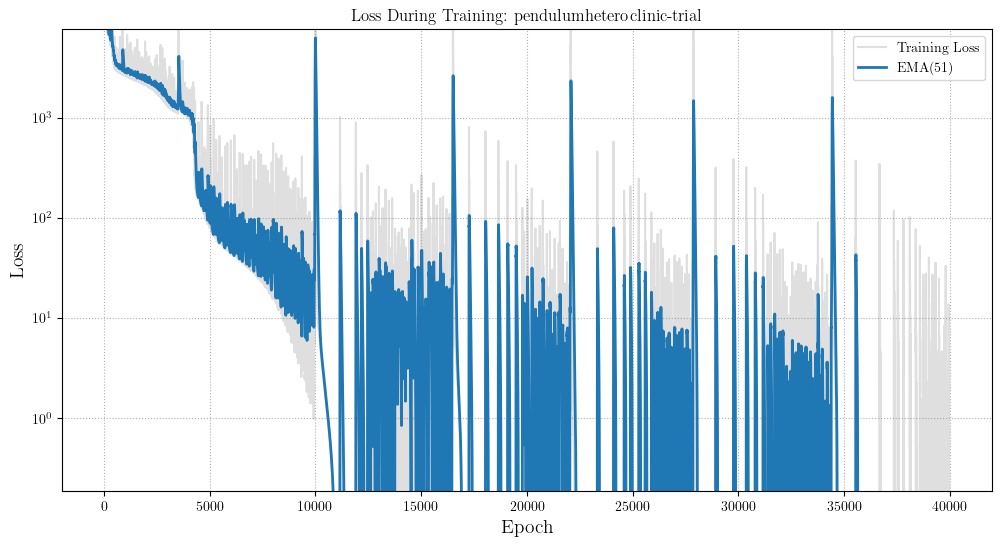

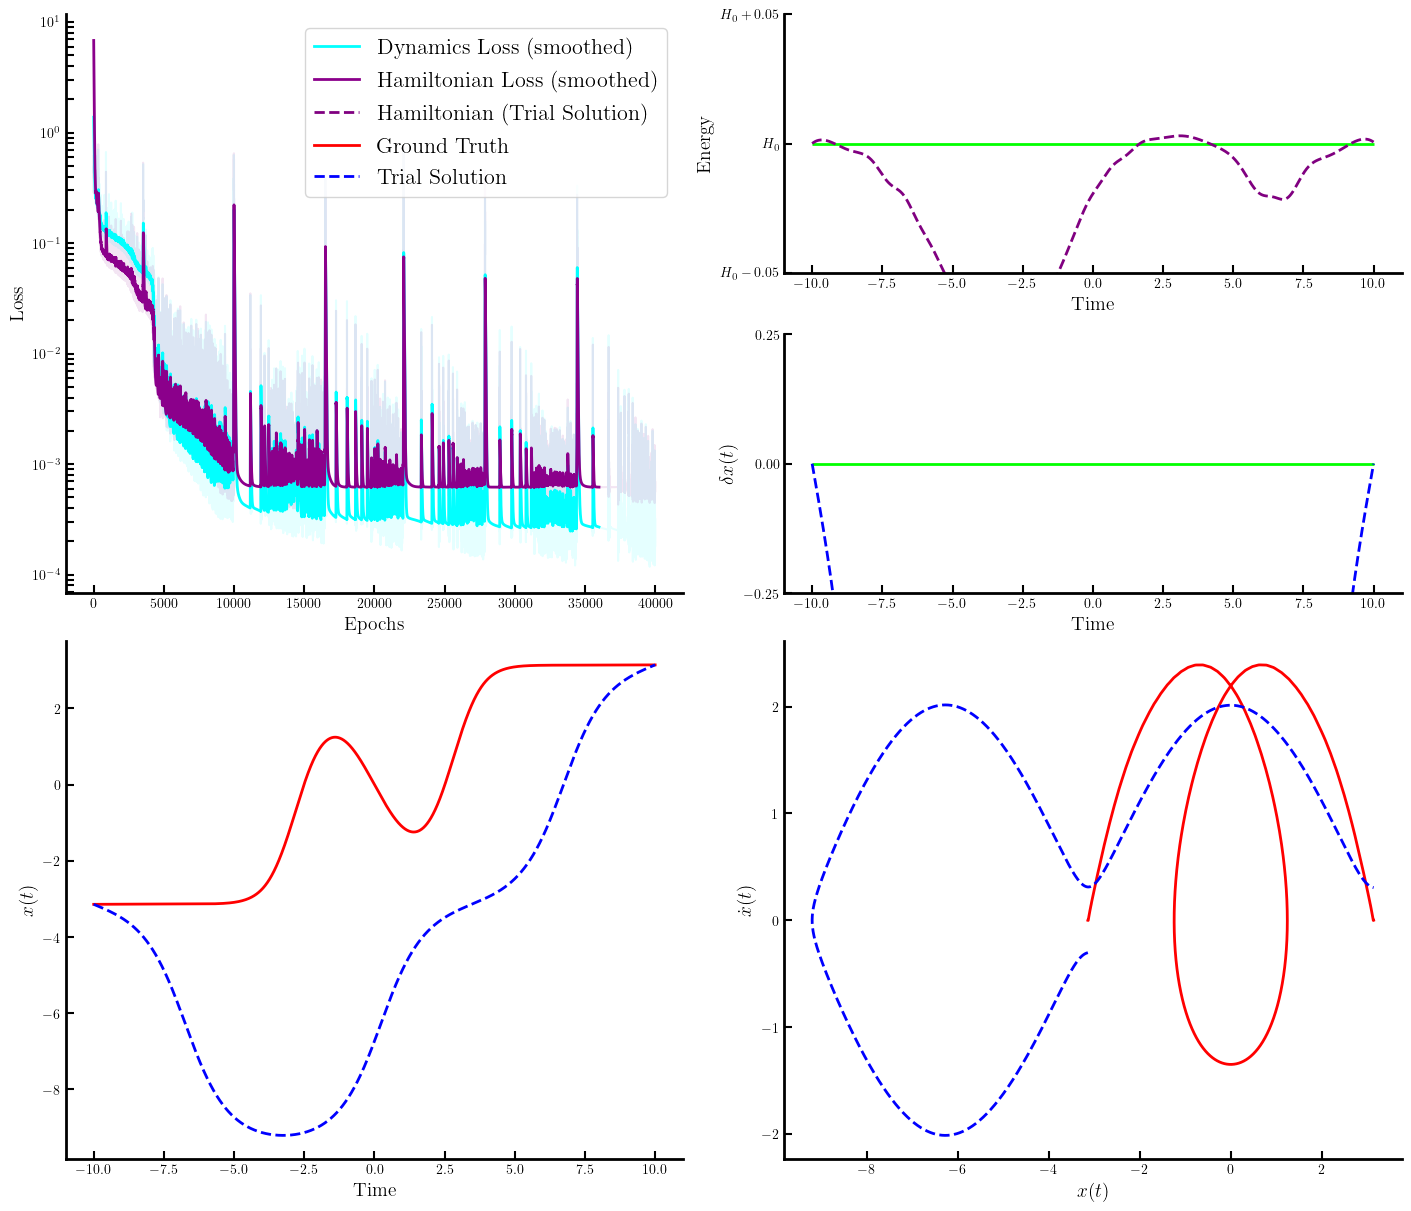

  0%|                                       | 1/40000 [00:00<1:53:29,  5.87it/s]

122839.42763084847


  0%|                                     | 101/40000 [00:14<1:33:23,  7.12it/s]

9656.70883044687


  1%|▏                                    | 201/40000 [00:28<1:34:20,  7.03it/s]

4572.488401270204


  1%|▎                                    | 301/40000 [00:42<1:30:20,  7.32it/s]

3575.064553278572


  1%|▎                                    | 401/40000 [00:56<1:31:12,  7.24it/s]

3063.6611370201863


  1%|▍                                    | 501/40000 [01:10<1:37:44,  6.74it/s]

2587.234246545616


  2%|▌                                    | 601/40000 [01:24<1:35:04,  6.91it/s]

2014.2585046364652


  2%|▋                                    | 701/40000 [01:39<1:37:07,  6.74it/s]

1595.7048010380577


  2%|▋                                    | 801/40000 [01:53<1:34:40,  6.90it/s]

1440.3081781691


  2%|▊                                    | 901/40000 [02:08<1:31:15,  7.14it/s]

1337.4110490282844


  3%|▉                                   | 1001/40000 [02:22<1:32:23,  7.04it/s]

1261.9986668857396


  3%|▉                                   | 1101/40000 [02:36<1:33:56,  6.90it/s]

1207.9151962183469


  3%|█                                   | 1201/40000 [02:51<1:30:47,  7.12it/s]

1167.1874499125481


  3%|█▏                                  | 1301/40000 [03:05<1:32:13,  6.99it/s]

1133.3214095158105


  4%|█▎                                  | 1401/40000 [03:20<1:32:18,  6.97it/s]

1107.96681360799


  4%|█▎                                  | 1501/40000 [03:34<1:30:59,  7.05it/s]

1114.5913534064694


  4%|█▍                                  | 1601/40000 [03:48<1:32:01,  6.95it/s]

1067.4072103768026


  4%|█▌                                  | 1701/40000 [04:03<1:32:06,  6.93it/s]

1051.1095800023108


  5%|█▌                                  | 1801/40000 [04:17<1:34:54,  6.71it/s]

1032.9631574020445


  5%|█▋                                  | 1901/40000 [04:32<1:32:53,  6.84it/s]

1016.5798156010877


  5%|█▊                                  | 2001/40000 [04:46<1:30:47,  6.98it/s]

1048.4810854887921


  5%|█▉                                  | 2101/40000 [05:00<1:30:01,  7.02it/s]

982.3292893556487


  6%|█▉                                  | 2201/40000 [05:15<1:31:58,  6.85it/s]

1010.008558240948


  6%|██                                  | 2301/40000 [05:30<1:31:38,  6.86it/s]

948.3516320522585


  6%|██▏                                 | 2401/40000 [05:44<1:29:25,  7.01it/s]

934.0451703240017


  6%|██▎                                 | 2501/40000 [05:58<1:31:02,  6.87it/s]

916.7711363337795


  7%|██▎                                 | 2601/40000 [06:13<1:35:26,  6.53it/s]

903.0911958271328


  7%|██▍                                 | 2701/40000 [06:27<1:30:30,  6.87it/s]

947.4132733661796


  7%|██▌                                 | 2801/40000 [06:42<1:28:56,  6.97it/s]

877.9519748570107


  7%|██▌                                 | 2901/40000 [06:56<1:27:57,  7.03it/s]

867.8336127491148


  8%|██▋                                 | 3001/40000 [07:11<1:33:20,  6.61it/s]

887.5335719487673


  8%|██▊                                 | 3101/40000 [07:26<1:30:27,  6.80it/s]

849.3265892547784


  8%|██▉                                 | 3201/40000 [07:40<1:28:21,  6.94it/s]

847.9734180465113


  8%|██▉                                 | 3301/40000 [07:55<1:28:14,  6.93it/s]

855.665930261114


  9%|███                                 | 3401/40000 [08:10<1:26:14,  7.07it/s]

932.3611215639241


  9%|███▏                                | 3501/40000 [08:25<2:09:58,  4.68it/s]

873.8923175368857


  9%|███▏                                | 3601/40000 [08:39<1:24:13,  7.20it/s]

818.0765038701873


  9%|███▎                                | 3701/40000 [08:54<1:24:08,  7.19it/s]

816.6568366660931


 10%|███▍                                | 3801/40000 [09:08<1:27:37,  6.89it/s]

820.932280641465


 10%|███▌                                | 3901/40000 [09:22<1:25:54,  7.00it/s]

805.1203536486116


 10%|███▌                                | 4001/40000 [09:36<1:24:55,  7.07it/s]

801.4511123706667


 10%|███▋                                | 4101/40000 [09:51<1:24:18,  7.10it/s]

806.5305213692354


 11%|███▊                                | 4201/40000 [10:05<1:21:58,  7.28it/s]

984.050661805883


 11%|███▊                                | 4301/40000 [10:19<1:34:37,  6.29it/s]

780.453504832484


 11%|███▉                                | 4401/40000 [10:33<1:23:01,  7.15it/s]

805.2003845254756


 11%|████                                | 4501/40000 [10:47<1:23:36,  7.08it/s]

772.2465721148725


 12%|████▏                               | 4601/40000 [11:02<1:22:49,  7.12it/s]

776.1788991576104


 12%|████▏                               | 4701/40000 [11:16<1:23:43,  7.03it/s]

772.4419818413528


 12%|████▎                               | 4801/40000 [11:31<1:24:20,  6.96it/s]

757.7397881766847


 12%|████▍                               | 4901/40000 [11:45<1:22:43,  7.07it/s]

801.6706697193204


 13%|████▌                               | 5001/40000 [11:59<1:21:54,  7.12it/s]

769.9591635850625


 13%|████▌                               | 5101/40000 [12:13<1:26:08,  6.75it/s]

750.6719936017925


 13%|████▋                               | 5201/40000 [12:27<1:22:48,  7.00it/s]

793.1526038212392


 13%|████▊                               | 5301/40000 [12:41<1:22:34,  7.00it/s]

737.1882068377149


 14%|████▊                               | 5401/40000 [12:55<1:21:21,  7.09it/s]

732.4652476717735


 14%|████▉                               | 5501/40000 [13:10<1:28:15,  6.51it/s]

727.8724087576395


 14%|█████                               | 5601/40000 [13:24<1:20:02,  7.16it/s]

725.8854126623297


 14%|█████▏                              | 5701/40000 [13:39<1:21:25,  7.02it/s]

726.6834781601433


 15%|█████▏                              | 5801/40000 [13:53<1:21:08,  7.02it/s]

734.4863097129397


 15%|█████▎                              | 5901/40000 [14:07<1:23:50,  6.78it/s]

712.1705253207128


 15%|█████▍                              | 6001/40000 [14:21<1:20:10,  7.07it/s]

782.4267323438327


 15%|█████▍                              | 6101/40000 [14:37<1:19:45,  7.08it/s]

725.6451291910408


 16%|█████▌                              | 6201/40000 [14:51<1:21:20,  6.92it/s]

701.0898586303584


 16%|█████▋                              | 6301/40000 [15:06<1:16:59,  7.29it/s]

699.0792341870614


 16%|█████▊                              | 6401/40000 [15:21<1:22:07,  6.82it/s]

712.1431299450782


 16%|█████▊                              | 6501/40000 [15:35<1:18:38,  7.10it/s]

702.3187340490169


 17%|█████▉                              | 6601/40000 [15:49<1:19:23,  7.01it/s]

705.579706740215


 17%|██████                              | 6701/40000 [16:03<1:18:52,  7.04it/s]

707.618574688292


 17%|██████                              | 6801/40000 [16:19<2:31:42,  3.65it/s]

710.7511751247353


 17%|██████▏                             | 6901/40000 [16:38<2:07:35,  4.32it/s]

704.1626869708612


 18%|██████▎                             | 7001/40000 [16:53<1:20:25,  6.84it/s]

774.6716439644927


 18%|██████▍                             | 7101/40000 [17:08<1:15:10,  7.29it/s]

671.6199406790863


 18%|██████▍                             | 7201/40000 [17:22<1:17:41,  7.04it/s]

705.8103454910304


 18%|██████▌                             | 7301/40000 [17:36<1:15:06,  7.26it/s]

668.4230755615449


 19%|██████▋                             | 7401/40000 [17:50<1:14:46,  7.27it/s]

656.234199206458


 19%|██████▊                             | 7501/40000 [18:04<1:14:14,  7.30it/s]

650.758019632707


 19%|██████▊                             | 7601/40000 [18:18<1:15:13,  7.18it/s]

647.224260801599


 19%|██████▉                             | 7701/40000 [18:32<1:14:04,  7.27it/s]

643.9476012301316


 20%|███████                             | 7801/40000 [18:46<1:14:41,  7.18it/s]

643.0497861286058


 20%|███████                             | 7901/40000 [19:00<1:13:22,  7.29it/s]

638.5701553802759


 20%|███████▏                            | 8001/40000 [19:14<1:17:33,  6.88it/s]

637.1234648641015


 20%|███████▎                            | 8101/40000 [19:29<1:12:51,  7.30it/s]

631.6947370952887


 21%|███████▍                            | 8201/40000 [19:43<1:13:59,  7.16it/s]

640.0202473306965


 21%|███████▍                            | 8301/40000 [19:57<1:13:54,  7.15it/s]

622.9962376564964


 21%|███████▌                            | 8401/40000 [20:12<1:11:32,  7.36it/s]

619.9199458947576


 21%|███████▋                            | 8501/40000 [20:26<1:13:31,  7.14it/s]

618.3314889894245


 22%|███████▋                            | 8601/40000 [20:39<1:14:05,  7.06it/s]

702.49521592984


 22%|███████▊                            | 8701/40000 [20:53<1:16:36,  6.81it/s]

609.7273578956771


 22%|███████▉                            | 8801/40000 [21:07<1:10:26,  7.38it/s]

607.4987144058148


 22%|████████                            | 8901/40000 [21:21<1:11:14,  7.28it/s]

688.8087337692931


 23%|████████                            | 9001/40000 [21:35<1:12:17,  7.15it/s]

610.4615208368257


 23%|████████▏                           | 9101/40000 [21:50<1:19:02,  6.52it/s]

607.199395707406


 23%|████████▎                           | 9201/40000 [22:04<1:10:58,  7.23it/s]

593.9901354324364


 23%|████████▎                           | 9301/40000 [22:18<1:12:16,  7.08it/s]

592.6102111998048


 24%|████████▍                           | 9401/40000 [22:32<1:09:55,  7.29it/s]

665.1752812045653


 24%|████████▌                           | 9501/40000 [22:46<1:12:50,  6.98it/s]

588.4726919769744


 24%|████████▋                           | 9601/40000 [23:00<1:15:50,  6.68it/s]

591.1649957499035


 24%|████████▋                           | 9701/40000 [23:14<1:14:24,  6.79it/s]

668.6687797929853


 25%|████████▊                           | 9801/40000 [23:29<1:11:42,  7.02it/s]

588.3048047634322


 25%|████████▉                           | 9901/40000 [23:43<1:09:37,  7.21it/s]

611.152942524921


 25%|████████▊                          | 10001/40000 [23:57<1:15:40,  6.61it/s]

713.6778929182335


 25%|████████▊                          | 10101/40000 [24:13<1:24:55,  5.87it/s]

578.1687134409782


 26%|████████▉                          | 10201/40000 [24:29<1:10:59,  7.00it/s]

564.530392003272


 26%|█████████                          | 10301/40000 [24:44<1:20:18,  6.16it/s]

576.2186989631163


 26%|█████████                          | 10401/40000 [25:00<1:14:20,  6.64it/s]

573.027900211202


 26%|█████████▏                         | 10501/40000 [25:15<1:18:16,  6.28it/s]

609.1701290760029


 27%|█████████▎                         | 10601/40000 [25:32<1:16:24,  6.41it/s]

555.6115554725507


 27%|█████████▎                         | 10701/40000 [25:47<1:15:12,  6.49it/s]

583.3149879256118


 27%|█████████▍                         | 10801/40000 [26:03<1:14:23,  6.54it/s]

546.7635320161176


 27%|█████████▌                         | 10901/40000 [26:18<1:30:27,  5.36it/s]

545.7859964329039


 28%|█████████▋                         | 11001/40000 [26:36<1:16:01,  6.36it/s]

542.7190953504087


 28%|█████████▋                         | 11101/40000 [26:54<1:18:36,  6.13it/s]

602.2718480077608


 28%|█████████▊                         | 11201/40000 [27:11<1:23:58,  5.72it/s]

541.0603691798271


 28%|█████████▉                         | 11301/40000 [27:28<1:24:41,  5.65it/s]

535.3506412698939


 29%|█████████▉                         | 11401/40000 [27:45<1:14:34,  6.39it/s]

552.1279215348499


 29%|██████████                         | 11501/40000 [28:01<1:15:51,  6.26it/s]

529.5747912663342


 29%|██████████▏                        | 11601/40000 [28:18<1:19:36,  5.95it/s]

527.6204959471766


 29%|██████████▏                        | 11701/40000 [28:35<1:24:07,  5.61it/s]

526.4106751864219


 30%|██████████▎                        | 11801/40000 [28:52<1:28:32,  5.31it/s]

655.7780482260889


 30%|██████████▍                        | 11901/40000 [29:09<1:17:03,  6.08it/s]

521.5244868323109


 30%|██████████▌                        | 12001/40000 [29:26<1:18:47,  5.92it/s]

540.3044082041367


 30%|██████████▌                        | 12101/40000 [29:42<1:15:12,  6.18it/s]

517.1262534058594


 31%|██████████▋                        | 12201/40000 [29:58<1:13:47,  6.28it/s]

513.025030062534


 31%|██████████▊                        | 12301/40000 [30:14<1:13:48,  6.25it/s]

533.2342424325777


 31%|██████████▊                        | 12401/40000 [30:31<1:13:23,  6.27it/s]

517.6113009404742


 31%|██████████▉                        | 12501/40000 [30:47<1:15:02,  6.11it/s]

528.675910569406


 32%|███████████                        | 12601/40000 [31:05<1:13:48,  6.19it/s]

520.0742775325866


 32%|███████████                        | 12701/40000 [31:21<1:12:49,  6.25it/s]

578.6631481282545


 32%|███████████▏                       | 12801/40000 [31:37<1:07:53,  6.68it/s]

504.60801280715845


 32%|███████████▎                       | 12901/40000 [31:52<1:10:22,  6.42it/s]

497.98368066672714


 33%|███████████▍                       | 13001/40000 [32:08<1:09:44,  6.45it/s]

521.8738512469324


 33%|███████████▍                       | 13101/40000 [32:24<1:08:06,  6.58it/s]

542.6052248727012


 33%|███████████▌                       | 13201/40000 [32:39<1:09:26,  6.43it/s]

603.7878815772724


 33%|███████████▋                       | 13301/40000 [32:55<1:10:22,  6.32it/s]

492.1598656000861


 34%|███████████▋                       | 13401/40000 [33:11<1:12:11,  6.14it/s]

488.4765908443814


 34%|███████████▊                       | 13501/40000 [33:26<1:09:19,  6.37it/s]

534.3432534262587


 34%|███████████▉                       | 13601/40000 [33:42<1:07:54,  6.48it/s]

487.0581017876623


 34%|███████████▉                       | 13701/40000 [33:58<1:06:23,  6.60it/s]

531.8203897222525


 35%|████████████                       | 13801/40000 [34:13<1:10:27,  6.20it/s]

621.3349507917926


 35%|████████████▏                      | 13901/40000 [34:29<1:06:30,  6.54it/s]

483.57099687384755


 35%|████████████▎                      | 14001/40000 [34:45<1:06:14,  6.54it/s]

488.90855193019695


 35%|████████████▎                      | 14101/40000 [35:01<1:07:15,  6.42it/s]

533.8812505941931


 36%|████████████▍                      | 14201/40000 [35:16<1:06:44,  6.44it/s]

505.070347178402


 36%|████████████▌                      | 14301/40000 [35:32<1:05:39,  6.52it/s]

504.955034493535


 36%|████████████▌                      | 14401/40000 [35:49<1:22:26,  5.18it/s]

509.45813907365914


 36%|████████████▋                      | 14501/40000 [36:05<1:04:33,  6.58it/s]

472.5694455185485


 37%|████████████▊                      | 14601/40000 [36:20<1:04:21,  6.58it/s]

573.0524972791256


 37%|████████████▊                      | 14701/40000 [36:35<1:03:56,  6.59it/s]

502.61179643392995


 37%|████████████▉                      | 14801/40000 [36:51<1:02:38,  6.70it/s]

808.9338428790617


 37%|█████████████                      | 14901/40000 [37:06<1:02:49,  6.66it/s]

651.4535833659254


 38%|█████████████▏                     | 15001/40000 [37:21<1:01:50,  6.74it/s]

489.4267501237112


 38%|█████████████▏                     | 15101/40000 [37:36<1:02:19,  6.66it/s]

485.2122152310511


 38%|█████████████▎                     | 15201/40000 [37:51<1:01:26,  6.73it/s]

470.4204422582792


 38%|█████████████▍                     | 15301/40000 [38:07<1:08:29,  6.01it/s]

543.5839455362699


 39%|█████████████▍                     | 15401/40000 [38:22<1:02:29,  6.56it/s]

456.85569183644566


 39%|█████████████▌                     | 15501/40000 [38:38<1:01:39,  6.62it/s]

478.3249663691755


 39%|█████████████▋                     | 15601/40000 [38:53<1:02:24,  6.52it/s]

473.1385153335948


 39%|█████████████▋                     | 15701/40000 [39:08<1:00:26,  6.70it/s]

498.49191162396806


 40%|██████████████▌                      | 15801/40000 [39:23<59:58,  6.72it/s]

1004.2404991784109


 40%|█████████████▉                     | 15901/40000 [39:40<1:04:20,  6.24it/s]

448.5795014481557


 40%|██████████████                     | 16001/40000 [39:56<1:04:00,  6.25it/s]

472.1555041248243


 40%|██████████████                     | 16101/40000 [40:12<1:02:04,  6.42it/s]

448.48450831890773


 41%|██████████████▏                    | 16201/40000 [40:29<1:04:57,  6.11it/s]

450.7101113949891


 41%|██████████████▎                    | 16301/40000 [40:45<1:00:27,  6.53it/s]

447.6447009843671


 41%|██████████████▎                    | 16401/40000 [41:01<1:01:46,  6.37it/s]

457.87208202310705


 41%|██████████████▍                    | 16501/40000 [41:16<1:00:52,  6.43it/s]

483.2413710125619


 42%|██████████████▌                    | 16601/40000 [41:32<1:00:42,  6.42it/s]

461.4902695670145


 42%|██████████████▌                    | 16701/40000 [41:47<1:03:44,  6.09it/s]

455.0931818694091


 42%|██████████████▋                    | 16801/40000 [42:03<1:00:55,  6.35it/s]

474.07961431434944


 42%|██████████████▊                    | 16901/40000 [42:20<1:06:58,  5.75it/s]

449.69080799856005


 43%|██████████████▉                    | 17001/40000 [42:37<1:00:39,  6.32it/s]

466.2449344233309


 43%|██████████████▉                    | 17101/40000 [42:53<1:05:23,  5.84it/s]

579.8645403885616


 43%|███████████████▉                     | 17201/40000 [43:10<58:52,  6.45it/s]

522.1634601632129


 43%|███████████████▏                   | 17301/40000 [43:26<1:00:37,  6.24it/s]

473.8853344017302


 44%|████████████████                     | 17401/40000 [43:42<58:36,  6.43it/s]

449.98818485968013


 44%|███████████████▎                   | 17501/40000 [43:58<1:00:37,  6.18it/s]

474.2915058066367


 44%|████████████████▎                    | 17601/40000 [44:14<59:47,  6.24it/s]

445.5193087859902


 44%|████████████████▎                    | 17701/40000 [44:30<56:59,  6.52it/s]

462.2370343842848


 45%|████████████████▍                    | 17801/40000 [44:46<58:52,  6.28it/s]

581.9615057878898


 45%|████████████████▌                    | 17901/40000 [45:02<58:05,  6.34it/s]

432.59610582108996


 45%|████████████████▋                    | 18001/40000 [45:18<59:02,  6.21it/s]

788.1998018812161


 45%|████████████████▋                    | 18101/40000 [45:34<56:58,  6.41it/s]

442.6173576739804


 46%|████████████████▊                    | 18201/40000 [45:50<58:15,  6.24it/s]

427.810985019499


 46%|████████████████▉                    | 18301/40000 [46:05<57:39,  6.27it/s]

429.4531181133999


 46%|█████████████████                    | 18401/40000 [46:24<58:03,  6.20it/s]

464.33324067624767


 46%|█████████████████                    | 18501/40000 [46:41<56:51,  6.30it/s]

445.6465932092078


 47%|█████████████████▏                   | 18601/40000 [46:57<55:59,  6.37it/s]

424.41383280596654


 47%|█████████████████▎                   | 18701/40000 [47:13<54:11,  6.55it/s]

435.6664573835667


 47%|█████████████████▍                   | 18801/40000 [47:28<56:48,  6.22it/s]

431.43152880491743


 47%|█████████████████▍                   | 18901/40000 [47:44<54:35,  6.44it/s]

603.7206097647954


 48%|█████████████████▌                   | 19001/40000 [48:00<55:38,  6.29it/s]

429.7062501282945


 48%|█████████████████▋                   | 19101/40000 [48:16<57:40,  6.04it/s]

419.81615353302493


 48%|█████████████████▊                   | 19201/40000 [48:31<56:01,  6.19it/s]

424.47763908381415


 48%|█████████████████▊                   | 19301/40000 [48:48<56:49,  6.07it/s]

423.56544615303676


 49%|█████████████████▉                   | 19401/40000 [49:04<54:33,  6.29it/s]

424.46429682991425


 49%|██████████████████                   | 19501/40000 [49:19<52:41,  6.48it/s]

497.71571777950675


 49%|█████████████████▏                 | 19601/40000 [49:36<1:04:19,  5.29it/s]

414.72181772081194


 49%|██████████████████▏                  | 19701/40000 [49:51<52:00,  6.51it/s]

444.0466711537042


 50%|██████████████████▎                  | 19801/40000 [50:07<51:39,  6.52it/s]

437.12169510433864


 50%|██████████████████▍                  | 19901/40000 [50:23<51:49,  6.46it/s]

431.34879996797946


 50%|██████████████████▌                  | 20001/40000 [50:39<51:03,  6.53it/s]

554.2120586873442


 50%|██████████████████▌                  | 20101/40000 [50:55<52:31,  6.31it/s]

431.31465697042404


 51%|██████████████████▋                  | 20201/40000 [51:11<55:45,  5.92it/s]

444.21884320805464


 51%|██████████████████▊                  | 20301/40000 [51:27<59:30,  5.52it/s]

696.790347147008


 51%|██████████████████▊                  | 20401/40000 [51:43<48:44,  6.70it/s]

421.7540436781317


 51%|██████████████████▉                  | 20501/40000 [51:57<44:58,  7.23it/s]

481.28938080824537


 52%|███████████████████                  | 20601/40000 [52:11<45:53,  7.05it/s]

415.0272575882182


 52%|███████████████████▏                 | 20701/40000 [52:26<45:40,  7.04it/s]

415.31929790680283


 52%|███████████████████▏                 | 20801/40000 [52:40<49:43,  6.44it/s]

407.93971945541114


 52%|███████████████████▎                 | 20901/40000 [52:55<43:51,  7.26it/s]

407.97378840616864


 53%|███████████████████▍                 | 21001/40000 [53:09<46:52,  6.75it/s]

644.620989365716


 53%|███████████████████▌                 | 21101/40000 [53:24<44:44,  7.04it/s]

410.62621888385644


 53%|██████████████████▌                | 21201/40000 [53:39<1:00:14,  5.20it/s]

407.98906289210163


 53%|███████████████████▋                 | 21301/40000 [53:54<46:15,  6.74it/s]

445.7123601916143


 54%|███████████████████▊                 | 21401/40000 [54:08<45:09,  6.86it/s]

405.34666398682634


 54%|███████████████████▉                 | 21501/40000 [54:23<45:26,  6.79it/s]

407.0594340874392


 54%|███████████████████▉                 | 21601/40000 [54:37<45:01,  6.81it/s]

413.4628367173251


 54%|████████████████████                 | 21701/40000 [54:52<44:23,  6.87it/s]

409.02219806028154


 55%|████████████████████▏                | 21801/40000 [55:06<43:40,  6.95it/s]

547.0630800080221


 55%|████████████████████▎                | 21901/40000 [55:21<46:40,  6.46it/s]

405.7294934001932


 55%|████████████████████▎                | 22001/40000 [55:36<41:46,  7.18it/s]

400.62324372367414


 55%|████████████████████▍                | 22101/40000 [55:50<42:45,  6.98it/s]

408.9085768185589


 56%|████████████████████▌                | 22201/40000 [56:05<42:09,  7.04it/s]

440.95284621462156


 56%|████████████████████▋                | 22301/40000 [56:19<41:43,  7.07it/s]

404.1694453289222


 56%|████████████████████▋                | 22401/40000 [56:33<40:40,  7.21it/s]

402.6815079101414


 56%|████████████████████▊                | 22501/40000 [56:48<41:52,  6.96it/s]

423.67966383812313


 57%|████████████████████▉                | 22601/40000 [57:02<41:19,  7.02it/s]

412.3257047926619


 57%|████████████████████▉                | 22701/40000 [57:17<45:53,  6.28it/s]

409.7474974994671


 57%|█████████████████████                | 22801/40000 [57:32<42:41,  6.71it/s]

421.3386804202819


 57%|█████████████████████▏               | 22901/40000 [57:46<42:37,  6.69it/s]

439.57561292170146


 58%|█████████████████████▎               | 23001/40000 [58:02<46:49,  6.05it/s]

452.4929464593283


 58%|█████████████████████▎               | 23101/40000 [58:17<44:07,  6.38it/s]

400.0417418104338


 58%|█████████████████████▍               | 23201/40000 [58:31<39:48,  7.03it/s]

455.03536628708787


 58%|█████████████████████▌               | 23301/40000 [58:46<41:50,  6.65it/s]

607.6167299644848


 59%|█████████████████████▋               | 23401/40000 [59:01<39:28,  7.01it/s]

415.19867802734234


 59%|█████████████████████▋               | 23501/40000 [59:16<39:45,  6.92it/s]

482.4630266201923


 59%|█████████████████████▊               | 23601/40000 [59:30<40:18,  6.78it/s]

400.065292267033


 59%|█████████████████████▉               | 23701/40000 [59:44<38:11,  7.11it/s]

749.9871538038301


 60%|██████████████████████               | 23801/40000 [59:59<37:56,  7.11it/s]

443.2299964824376


 60%|████████████████████▉              | 23901/40000 [1:00:13<41:17,  6.50it/s]

416.9089801057064


 60%|█████████████████████              | 24001/40000 [1:00:27<39:04,  6.82it/s]

447.0347708387209


 60%|█████████████████████              | 24101/40000 [1:00:42<38:58,  6.80it/s]

395.2855563551044


 61%|█████████████████████▏             | 24201/40000 [1:00:56<37:17,  7.06it/s]

406.67158178211764


 61%|█████████████████████▎             | 24301/40000 [1:01:11<40:25,  6.47it/s]

421.9564564636436


 61%|█████████████████████▎             | 24401/40000 [1:01:26<38:50,  6.69it/s]

466.0558869252376


 61%|█████████████████████▍             | 24501/40000 [1:01:40<36:08,  7.15it/s]

392.3568115090673


 62%|█████████████████████▌             | 24601/40000 [1:01:55<37:20,  6.87it/s]

567.6037648058232


 62%|█████████████████████▌             | 24701/40000 [1:02:10<41:50,  6.09it/s]

388.5361280195804


 62%|█████████████████████▋             | 24801/40000 [1:02:25<38:30,  6.58it/s]

404.728615352805


 62%|█████████████████████▊             | 24901/40000 [1:02:40<36:52,  6.83it/s]

388.3843210872245


 63%|█████████████████████▉             | 25001/40000 [1:02:54<37:26,  6.68it/s]

596.7992403293135


 63%|█████████████████████▉             | 25101/40000 [1:03:09<36:52,  6.73it/s]

418.6842520623322


 63%|██████████████████████             | 25201/40000 [1:03:24<37:24,  6.59it/s]

426.76966182154274


 63%|██████████████████████▏            | 25301/40000 [1:03:39<37:24,  6.55it/s]

387.4540387948766


 64%|██████████████████████▏            | 25401/40000 [1:03:54<35:44,  6.81it/s]

443.7438890576782


 64%|██████████████████████▎            | 25501/40000 [1:04:09<36:16,  6.66it/s]

495.1706290178884


 64%|██████████████████████▍            | 25601/40000 [1:04:24<34:13,  7.01it/s]

446.9057835224633


 64%|██████████████████████▍            | 25701/40000 [1:04:38<39:40,  6.01it/s]

397.4874723872214


 65%|██████████████████████▌            | 25801/40000 [1:04:53<34:40,  6.82it/s]

462.4689180224782


 65%|██████████████████████▋            | 25901/40000 [1:05:08<34:04,  6.90it/s]

396.8440357019357


 65%|██████████████████████▊            | 26001/40000 [1:05:23<34:46,  6.71it/s]

385.8361762195873


 65%|██████████████████████▊            | 26101/40000 [1:05:37<35:35,  6.51it/s]

430.5072390399402


 66%|██████████████████████▉            | 26201/40000 [1:05:54<32:48,  7.01it/s]

425.13055811640305


 66%|███████████████████████            | 26301/40000 [1:06:09<34:11,  6.68it/s]

453.3780563542035


 66%|███████████████████████            | 26401/40000 [1:06:25<34:35,  6.55it/s]

404.7744684293667


 66%|███████████████████████▏           | 26501/40000 [1:06:40<31:46,  7.08it/s]

450.7525643827231


 67%|███████████████████████▎           | 26601/40000 [1:06:56<35:02,  6.37it/s]

536.5897144730354


 67%|███████████████████████▎           | 26701/40000 [1:07:10<31:49,  6.97it/s]

395.0966430314336


 67%|███████████████████████▍           | 26801/40000 [1:07:25<33:01,  6.66it/s]

396.35665813431535


 67%|███████████████████████▌           | 26901/40000 [1:07:40<30:33,  7.14it/s]

405.36771437360954


 68%|███████████████████████▋           | 27001/40000 [1:07:56<31:16,  6.93it/s]

440.7392534251999


 68%|███████████████████████▋           | 27101/40000 [1:08:11<31:38,  6.80it/s]

380.9910009472664


 68%|███████████████████████▊           | 27201/40000 [1:08:26<32:56,  6.48it/s]

643.4125184682449


 68%|███████████████████████▉           | 27301/40000 [1:08:42<29:55,  7.07it/s]

450.3276614723486


 69%|███████████████████████▉           | 27401/40000 [1:08:57<31:42,  6.62it/s]

468.93230141584456


 69%|████████████████████████           | 27501/40000 [1:09:12<31:06,  6.70it/s]

382.9938427836719


 69%|████████████████████████▏          | 27601/40000 [1:09:27<30:18,  6.82it/s]

406.01019611716737


 69%|████████████████████████▏          | 27701/40000 [1:09:41<29:03,  7.05it/s]

669.5972161164177


 70%|████████████████████████▎          | 27801/40000 [1:09:57<33:00,  6.16it/s]

555.0125843487365


 70%|████████████████████████▍          | 27901/40000 [1:10:11<27:58,  7.21it/s]

496.58844635565254


 70%|████████████████████████▌          | 28001/40000 [1:10:25<28:23,  7.05it/s]

472.0116090124412


 70%|████████████████████████▌          | 28101/40000 [1:10:39<30:58,  6.40it/s]

405.51446875542206


 71%|████████████████████████▋          | 28201/40000 [1:10:53<28:36,  6.87it/s]

382.9560182016532


 71%|████████████████████████▊          | 28301/40000 [1:11:07<27:12,  7.16it/s]

394.13429856176094


 71%|████████████████████████▊          | 28401/40000 [1:11:21<27:09,  7.12it/s]

553.8674533133806


 71%|████████████████████████▉          | 28501/40000 [1:11:36<26:52,  7.13it/s]

611.7591914627105


 72%|█████████████████████████          | 28601/40000 [1:11:50<26:26,  7.19it/s]

381.3304920074323


 72%|█████████████████████████          | 28701/40000 [1:12:04<26:29,  7.11it/s]

377.3873893144441


 72%|█████████████████████████▏         | 28801/40000 [1:12:18<26:45,  6.97it/s]

372.5729526464169


 72%|█████████████████████████▎         | 28901/40000 [1:12:32<26:12,  7.06it/s]

465.3373440771317


 73%|█████████████████████████▍         | 29001/40000 [1:12:47<39:52,  4.60it/s]

374.92042723313943


 73%|█████████████████████████▍         | 29101/40000 [1:13:01<25:57,  7.00it/s]

400.33688592507326


 73%|█████████████████████████▌         | 29201/40000 [1:13:16<25:17,  7.12it/s]

370.8681697316222


 73%|█████████████████████████▋         | 29301/40000 [1:13:30<26:02,  6.85it/s]

373.6395969534723


 74%|█████████████████████████▋         | 29401/40000 [1:13:45<25:01,  7.06it/s]

389.417397949701


 74%|█████████████████████████▊         | 29501/40000 [1:13:59<25:02,  6.99it/s]

453.7190333487804


 74%|█████████████████████████▉         | 29601/40000 [1:14:14<26:30,  6.54it/s]

378.3936513802553


 74%|█████████████████████████▉         | 29701/40000 [1:14:29<25:16,  6.79it/s]

382.21898746658326


 75%|██████████████████████████         | 29801/40000 [1:14:43<24:35,  6.91it/s]

419.3266880169782


 75%|██████████████████████████▏        | 29901/40000 [1:14:58<23:58,  7.02it/s]

388.2777499113847


 75%|██████████████████████████▎        | 30001/40000 [1:15:12<24:52,  6.70it/s]

385.47676783619545


 75%|██████████████████████████▎        | 30101/40000 [1:15:27<24:30,  6.73it/s]

486.84169948830703


 76%|██████████████████████████▍        | 30201/40000 [1:15:41<23:33,  6.93it/s]

374.42173586227625


 76%|██████████████████████████▌        | 30301/40000 [1:15:56<23:25,  6.90it/s]

538.0036323613772


 76%|██████████████████████████▌        | 30401/40000 [1:16:10<22:46,  7.03it/s]

370.35761971444947


 76%|██████████████████████████▋        | 30501/40000 [1:16:25<24:22,  6.50it/s]

365.9876011986892


 77%|██████████████████████████▊        | 30601/40000 [1:16:39<22:18,  7.02it/s]

367.72202878313544


 77%|██████████████████████████▊        | 30701/40000 [1:16:54<22:42,  6.82it/s]

728.3173861598902


 77%|██████████████████████████▉        | 30801/40000 [1:17:09<23:02,  6.65it/s]

366.0393016731165


 77%|███████████████████████████        | 30901/40000 [1:17:24<21:47,  6.96it/s]

385.79950902474707


 78%|███████████████████████████▏       | 31001/40000 [1:17:39<21:24,  7.01it/s]

399.1975786423968


 78%|███████████████████████████▏       | 31101/40000 [1:17:53<21:37,  6.86it/s]

394.2956368664496


 78%|███████████████████████████▎       | 31201/40000 [1:18:07<21:14,  6.91it/s]

416.9800900928194


 78%|███████████████████████████▍       | 31301/40000 [1:18:22<20:34,  7.05it/s]

373.2786777571307


 79%|███████████████████████████▍       | 31401/40000 [1:18:36<20:37,  6.95it/s]

387.6891196101525


 79%|███████████████████████████▌       | 31501/40000 [1:18:51<20:31,  6.90it/s]

368.58150220507684


 79%|███████████████████████████▋       | 31601/40000 [1:19:06<20:03,  6.98it/s]

411.35009340599436


 79%|███████████████████████████▋       | 31701/40000 [1:19:20<20:20,  6.80it/s]

391.97408558817546


 80%|███████████████████████████▊       | 31801/40000 [1:19:35<19:41,  6.94it/s]

415.7479013134179


 80%|███████████████████████████▉       | 31901/40000 [1:19:49<19:31,  6.91it/s]

477.94265151691604


 80%|████████████████████████████       | 32001/40000 [1:20:03<18:27,  7.22it/s]

363.46038532493475


 80%|████████████████████████████       | 32101/40000 [1:20:18<19:37,  6.71it/s]

360.3835016684766


 81%|████████████████████████████▏      | 32201/40000 [1:20:33<19:34,  6.64it/s]

368.6791332594011


 81%|████████████████████████████▎      | 32301/40000 [1:20:47<18:53,  6.79it/s]

375.0819956342586


 81%|████████████████████████████▎      | 32401/40000 [1:21:02<18:36,  6.81it/s]

453.91778527499525


 81%|████████████████████████████▍      | 32501/40000 [1:21:16<18:02,  6.93it/s]

377.23542200478636


 82%|████████████████████████████▌      | 32601/40000 [1:21:31<18:00,  6.85it/s]

495.0994109768002


 82%|████████████████████████████▌      | 32701/40000 [1:21:45<17:50,  6.82it/s]

383.468217739724


 82%|████████████████████████████▋      | 32801/40000 [1:22:00<17:24,  6.89it/s]

660.0273931939862


 82%|████████████████████████████▊      | 32901/40000 [1:22:15<19:00,  6.22it/s]

373.91253207720877


 83%|████████████████████████████▉      | 33001/40000 [1:22:29<16:35,  7.03it/s]

404.2200795658721


 83%|████████████████████████████▉      | 33101/40000 [1:22:44<16:29,  6.97it/s]

357.8262449238313


 83%|█████████████████████████████      | 33201/40000 [1:22:58<16:49,  6.73it/s]

361.6496912175701


 83%|█████████████████████████████▏     | 33301/40000 [1:23:12<16:30,  6.76it/s]

372.90786630357286


 84%|█████████████████████████████▏     | 33401/40000 [1:23:28<16:10,  6.80it/s]

370.4522977635139


 84%|█████████████████████████████▎     | 33501/40000 [1:23:42<16:43,  6.47it/s]

402.9581705378869


 84%|█████████████████████████████▍     | 33601/40000 [1:23:57<15:20,  6.95it/s]

390.8959394214677


 84%|█████████████████████████████▍     | 33701/40000 [1:24:11<15:20,  6.84it/s]

450.66933677649115


 85%|█████████████████████████████▌     | 33801/40000 [1:24:26<15:17,  6.76it/s]

357.7667436463829


 85%|█████████████████████████████▋     | 33901/40000 [1:24:41<16:27,  6.17it/s]

413.15535885708175


 85%|█████████████████████████████▊     | 34001/40000 [1:24:56<14:44,  6.78it/s]

356.5853348685619


 85%|█████████████████████████████▊     | 34101/40000 [1:25:10<14:06,  6.97it/s]

376.4686085265039


 86%|█████████████████████████████▉     | 34201/40000 [1:25:24<13:44,  7.03it/s]

428.04338774209054


 86%|██████████████████████████████     | 34301/40000 [1:25:39<14:07,  6.72it/s]

360.22328041209136


 86%|██████████████████████████████     | 34401/40000 [1:25:53<13:06,  7.12it/s]

382.8436614105686


 86%|██████████████████████████████▏    | 34501/40000 [1:26:07<12:37,  7.26it/s]

452.3614064354038


 87%|██████████████████████████████▎    | 34601/40000 [1:26:22<12:55,  6.96it/s]

361.4280841671374


 87%|██████████████████████████████▎    | 34701/40000 [1:26:36<12:16,  7.20it/s]

379.2808243302249


 87%|██████████████████████████████▍    | 34801/40000 [1:26:50<12:33,  6.90it/s]

359.99297878724536


 87%|██████████████████████████████▌    | 34901/40000 [1:27:05<11:53,  7.15it/s]

352.37243971274347


 88%|██████████████████████████████▋    | 35001/40000 [1:27:19<12:03,  6.91it/s]

392.15974219389204


 88%|██████████████████████████████▋    | 35101/40000 [1:27:34<11:29,  7.11it/s]

369.22903996906604


 88%|██████████████████████████████▊    | 35201/40000 [1:27:48<11:39,  6.86it/s]

354.4338809793527


 88%|██████████████████████████████▉    | 35301/40000 [1:28:02<11:01,  7.10it/s]

402.9140751338507


 89%|██████████████████████████████▉    | 35401/40000 [1:28:17<11:35,  6.61it/s]

396.50467901454476


 89%|███████████████████████████████    | 35501/40000 [1:28:31<10:21,  7.24it/s]

441.9248440640765


 89%|███████████████████████████████▏   | 35601/40000 [1:28:45<10:20,  7.09it/s]

377.5397035939244


 89%|███████████████████████████████▏   | 35701/40000 [1:29:00<10:13,  7.01it/s]

362.3090598114714


 90%|███████████████████████████████▎   | 35801/40000 [1:29:14<09:41,  7.22it/s]

409.1941398656048


 90%|███████████████████████████████▍   | 35901/40000 [1:29:28<09:35,  7.13it/s]

470.93871094572825


 90%|███████████████████████████████▌   | 36001/40000 [1:29:42<09:35,  6.95it/s]

434.47208051333484


 90%|███████████████████████████████▌   | 36101/40000 [1:29:57<09:17,  7.00it/s]

353.3220415070297


 91%|███████████████████████████████▋   | 36201/40000 [1:30:11<09:11,  6.89it/s]

347.0086272814939


 91%|███████████████████████████████▊   | 36301/40000 [1:30:26<09:19,  6.62it/s]

351.5935021262022


 91%|███████████████████████████████▊   | 36401/40000 [1:30:40<08:24,  7.13it/s]

353.96783733622743


 91%|███████████████████████████████▉   | 36501/40000 [1:30:54<08:22,  6.97it/s]

413.0400347082215


 92%|████████████████████████████████   | 36601/40000 [1:31:09<07:56,  7.13it/s]

629.5323017470616


 92%|████████████████████████████████   | 36701/40000 [1:31:23<07:53,  6.96it/s]

348.66422014038716


 92%|████████████████████████████████▏  | 36801/40000 [1:31:37<07:44,  6.89it/s]

584.0100963041439


 92%|████████████████████████████████▎  | 36901/40000 [1:31:52<07:11,  7.18it/s]

348.6016587825073


 93%|████████████████████████████████▍  | 37001/40000 [1:32:06<07:07,  7.02it/s]

346.2945972615337


 93%|████████████████████████████████▍  | 37101/40000 [1:32:20<06:54,  7.00it/s]

347.45237116049975


 93%|████████████████████████████████▌  | 37201/40000 [1:32:35<06:37,  7.03it/s]

348.3910986921751


 93%|████████████████████████████████▋  | 37301/40000 [1:32:49<06:27,  6.96it/s]

344.6868246113172


 94%|████████████████████████████████▋  | 37401/40000 [1:33:04<06:13,  6.96it/s]

364.74898347927


 94%|████████████████████████████████▊  | 37501/40000 [1:33:18<06:02,  6.90it/s]

360.69453979149523


 94%|████████████████████████████████▉  | 37601/40000 [1:33:33<05:55,  6.76it/s]

418.8503083464913


 94%|████████████████████████████████▉  | 37701/40000 [1:33:48<05:26,  7.04it/s]

345.7663085464734


 95%|█████████████████████████████████  | 37801/40000 [1:34:02<05:17,  6.93it/s]

347.186363219379


 95%|█████████████████████████████████▏ | 37901/40000 [1:34:17<05:27,  6.40it/s]

458.2450139729183


 95%|█████████████████████████████████▎ | 38001/40000 [1:34:31<04:43,  7.05it/s]

347.24582782432617


 95%|█████████████████████████████████▎ | 38101/40000 [1:34:45<04:50,  6.55it/s]

351.81232097154066


 96%|█████████████████████████████████▍ | 38201/40000 [1:35:00<04:17,  6.99it/s]

374.39442110690584


 96%|█████████████████████████████████▌ | 38301/40000 [1:35:14<04:02,  7.00it/s]

340.8711698313854


 96%|█████████████████████████████████▌ | 38401/40000 [1:35:29<03:53,  6.86it/s]

342.80520072275624


 96%|█████████████████████████████████▋ | 38501/40000 [1:35:44<03:25,  7.31it/s]

432.27362935334264


 97%|█████████████████████████████████▊ | 38601/40000 [1:35:58<03:18,  7.04it/s]

363.76764034707116


 97%|█████████████████████████████████▊ | 38701/40000 [1:36:12<03:02,  7.13it/s]

440.1148422931336


 97%|█████████████████████████████████▉ | 38801/40000 [1:36:26<02:51,  7.01it/s]

346.07430996068274


 97%|██████████████████████████████████ | 38901/40000 [1:36:40<02:34,  7.14it/s]

388.23301504525716


 98%|██████████████████████████████████▏| 39001/40000 [1:36:55<02:20,  7.09it/s]

404.7578242572457


 98%|██████████████████████████████████▏| 39101/40000 [1:37:09<02:08,  7.01it/s]

474.14744779909086


 98%|██████████████████████████████████▎| 39201/40000 [1:37:23<01:51,  7.15it/s]

346.15917892169523


 98%|██████████████████████████████████▍| 39301/40000 [1:37:38<01:38,  7.07it/s]

531.8802443760594


 99%|██████████████████████████████████▍| 39401/40000 [1:37:52<01:24,  7.09it/s]

420.5123979744611


 99%|██████████████████████████████████▌| 39501/40000 [1:38:06<01:09,  7.21it/s]

494.929773901685


 99%|██████████████████████████████████▋| 39601/40000 [1:38:20<00:59,  6.75it/s]

421.83057833349136


 99%|██████████████████████████████████▋| 39701/40000 [1:38:35<00:42,  7.10it/s]

400.0778138817849


100%|██████████████████████████████████▊| 39801/40000 [1:38:49<00:27,  7.11it/s]

352.92790936328163


100%|██████████████████████████████████▉| 39901/40000 [1:39:04<00:14,  6.97it/s]

342.92445516793487


100%|███████████████████████████████████| 40000/40000 [1:39:18<00:00,  6.71it/s]


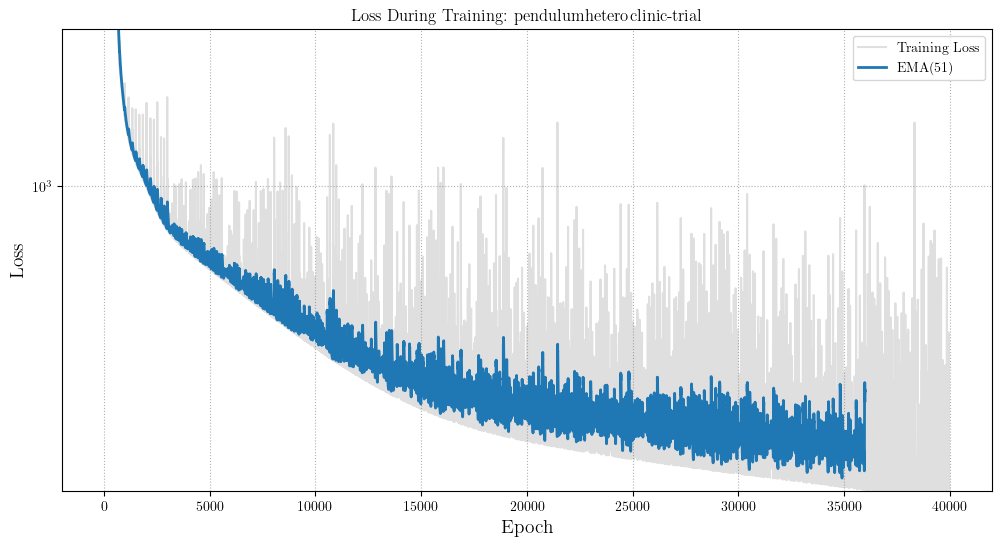

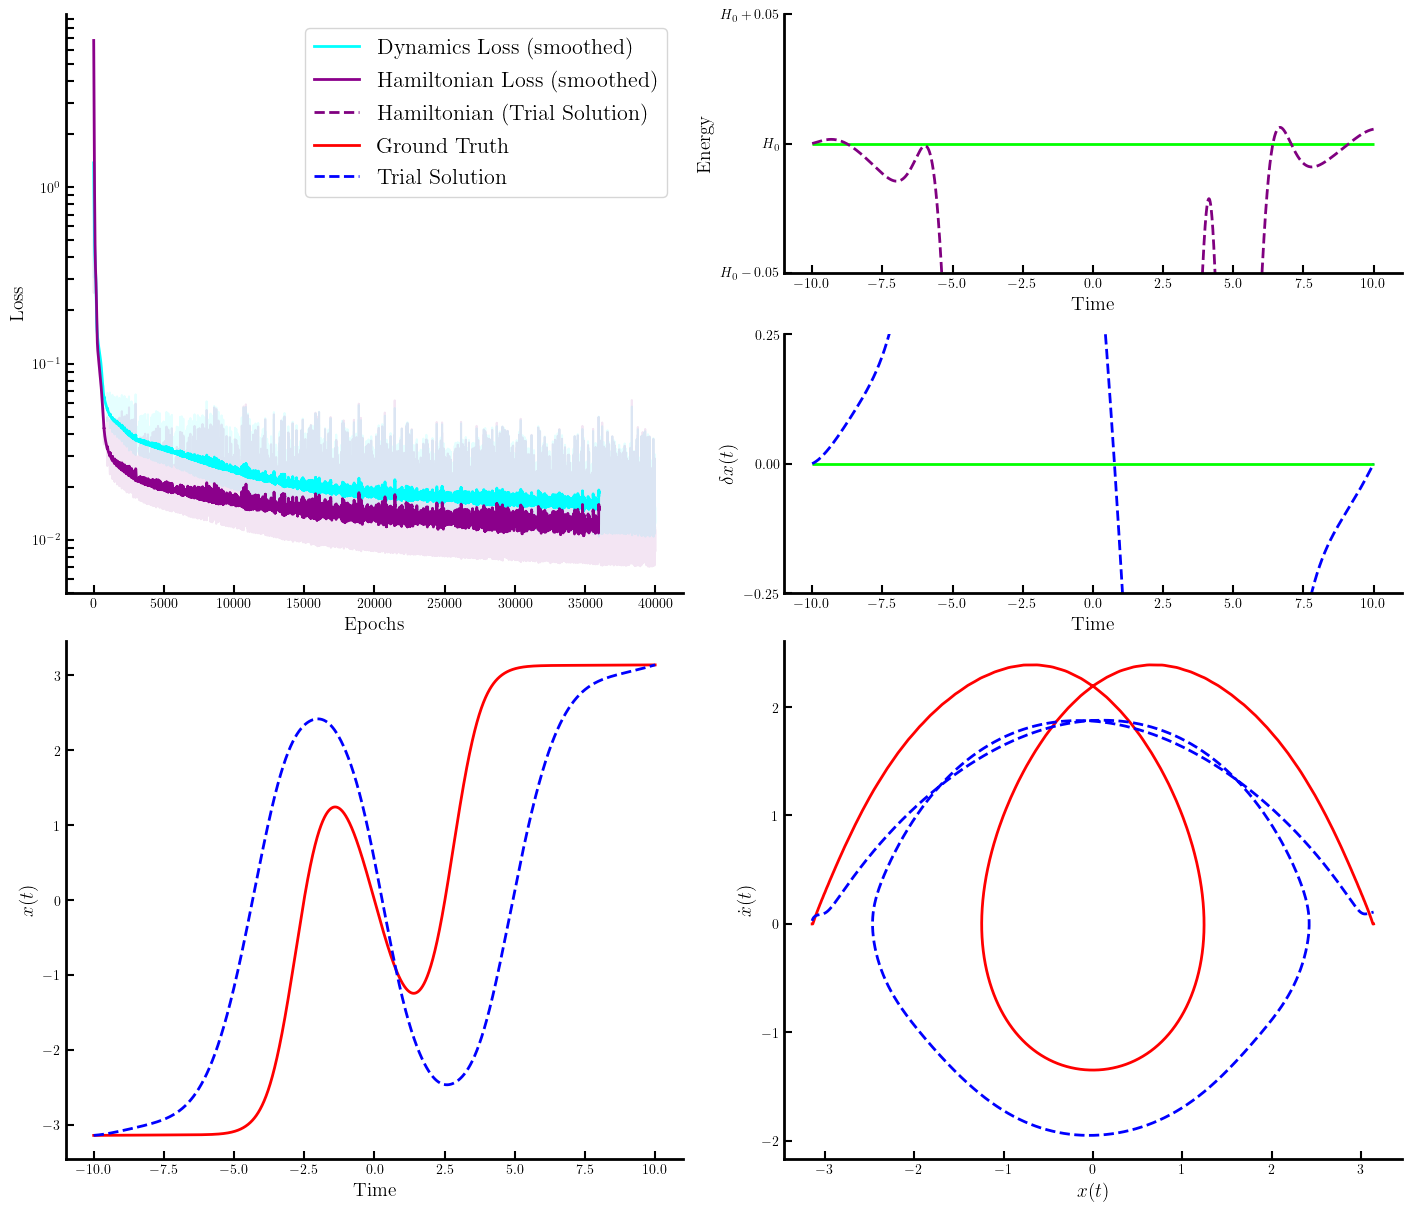

  0%|                                       | 1/40000 [00:00<1:54:17,  5.83it/s]

122839.42763084847


  0%|                                     | 101/40000 [00:14<1:34:45,  7.02it/s]

1098.3622478656005


  1%|▏                                    | 201/40000 [00:28<1:35:04,  6.98it/s]

811.5974946277714


  1%|▎                                    | 301/40000 [00:43<1:35:27,  6.93it/s]

659.4502248603312


  1%|▎                                    | 401/40000 [00:57<1:43:05,  6.40it/s]

530.5503933768183


  1%|▍                                    | 501/40000 [01:12<1:38:24,  6.69it/s]

421.831165501645


  2%|▌                                    | 601/40000 [01:26<1:33:40,  7.01it/s]

332.6331600580459


  2%|▋                                    | 701/40000 [01:41<1:32:51,  7.05it/s]

262.22349964657565


  2%|▋                                    | 801/40000 [01:55<1:34:02,  6.95it/s]

208.63408484155718


  2%|▊                                    | 901/40000 [02:09<1:31:59,  7.08it/s]

168.7962689311239


  3%|▉                                   | 1001/40000 [02:24<1:32:57,  6.99it/s]

139.24178339250616


  3%|▉                                   | 1101/40000 [02:38<1:33:09,  6.96it/s]

116.8163871356476


  3%|█                                   | 1201/40000 [02:52<1:30:36,  7.14it/s]

99.10353437515809


  3%|█▏                                  | 1301/40000 [03:07<2:28:12,  4.35it/s]

84.49697542065175


  4%|█▎                                  | 1401/40000 [03:22<1:34:22,  6.82it/s]

72.04096971607504


  4%|█▎                                  | 1501/40000 [03:36<1:34:16,  6.81it/s]

61.20160055536485


  4%|█▍                                  | 1601/40000 [03:51<1:30:46,  7.05it/s]

51.67566652128146


  4%|█▌                                  | 1701/40000 [04:05<1:40:22,  6.36it/s]

43.26933885884401


  5%|█▌                                  | 1801/40000 [04:20<1:30:52,  7.01it/s]

35.83549465161214


  5%|█▋                                  | 1901/40000 [04:34<1:29:55,  7.06it/s]

29.24730957118997


  5%|█▊                                  | 2001/40000 [04:48<1:31:57,  6.89it/s]

23.389979932946446


  5%|█▉                                  | 2101/40000 [05:03<1:32:38,  6.82it/s]

18.159797155736957


  6%|█▉                                  | 2201/40000 [05:18<1:28:11,  7.14it/s]

13.465285663459408


  6%|██                                  | 2301/40000 [05:32<1:54:17,  5.50it/s]

9.22820407966254


  6%|██▏                                 | 2401/40000 [05:47<1:31:39,  6.84it/s]

5.383698107761162


  6%|██▎                                 | 2501/40000 [06:01<1:30:03,  6.94it/s]

1.8795479411501521


  7%|██▎                                 | 2601/40000 [06:16<1:29:43,  6.95it/s]

-1.3252816949090347


  7%|██▍                                 | 2701/40000 [06:30<1:29:38,  6.94it/s]

-4.2624979139596


  7%|██▌                                 | 2801/40000 [06:45<1:28:48,  6.98it/s]

-6.956461362498971


  7%|██▌                                 | 2901/40000 [06:59<1:32:26,  6.69it/s]

-9.42606997535459


  8%|██▋                                 | 3001/40000 [07:14<1:29:33,  6.89it/s]

-11.686398392045731


  8%|██▊                                 | 3101/40000 [07:28<1:25:47,  7.17it/s]

-13.750021919560627


  8%|██▉                                 | 3201/40000 [07:42<1:26:02,  7.13it/s]

-15.628014687556597


  8%|██▉                                 | 3301/40000 [07:57<1:29:36,  6.83it/s]

-17.330652341586593


  9%|███                                 | 3401/40000 [08:11<1:27:28,  6.97it/s]

-18.867870673054487


  9%|███▏                                | 3501/40000 [08:25<1:27:20,  6.97it/s]

-20.249537071004944


  9%|███▏                                | 3601/40000 [08:40<1:25:22,  7.11it/s]

-21.48558705570156


  9%|███▎                                | 3701/40000 [08:54<1:27:00,  6.95it/s]

-22.586068536392848


 10%|███▍                                | 3801/40000 [09:09<1:28:05,  6.85it/s]

-23.561125677883172


 10%|███▌                                | 3901/40000 [09:23<1:24:10,  7.15it/s]

-24.42094470092995


 10%|███▌                                | 4001/40000 [09:38<1:29:11,  6.73it/s]

-25.17567660558573


 10%|███▋                                | 4101/40000 [09:52<1:24:34,  7.07it/s]

-25.83534680618978


 11%|███▊                                | 4201/40000 [10:06<1:26:01,  6.94it/s]

-26.409758611402427


 11%|███▊                                | 4301/40000 [10:21<1:20:39,  7.38it/s]

-26.908395801084044


 11%|███▉                                | 4401/40000 [10:35<1:22:14,  7.21it/s]

-27.34032869205958


 11%|████                                | 4501/40000 [10:49<1:25:44,  6.90it/s]

-27.714127609440325


 12%|████▏                               | 4601/40000 [11:04<1:25:23,  6.91it/s]

-28.037787289729543


 12%|████▏                               | 4701/40000 [11:18<1:23:49,  7.02it/s]

-28.31866526133559


 12%|████▎                               | 4801/40000 [11:33<1:28:31,  6.63it/s]

-28.563436600049293


 12%|████▍                               | 4901/40000 [11:47<1:22:29,  7.09it/s]

-28.778066635480712


 13%|████▌                               | 5001/40000 [12:02<1:22:26,  7.07it/s]

-28.96780223230536


 13%|████▌                               | 5101/40000 [12:16<1:21:29,  7.14it/s]

-29.137181260979503


 13%|████▋                               | 5201/40000 [12:31<1:24:34,  6.86it/s]

-29.290058894523742


 13%|████▊                               | 5301/40000 [12:45<1:28:47,  6.51it/s]

-29.4296485094066


 14%|████▊                               | 5401/40000 [13:00<1:20:52,  7.13it/s]

-29.55857430515201


 14%|████▉                               | 5501/40000 [13:14<1:19:59,  7.19it/s]

-29.678932341787853


 14%|█████                               | 5601/40000 [13:29<1:24:57,  6.75it/s]

-29.792356550026167


 14%|█████▏                              | 5701/40000 [13:44<1:22:12,  6.95it/s]

-29.90008638834857


 15%|█████▏                              | 5801/40000 [13:58<1:23:35,  6.82it/s]

-30.003033168017996


 15%|█████▎                              | 5901/40000 [14:13<1:23:13,  6.83it/s]

-30.10184258427076


 15%|█████▍                              | 6001/40000 [14:27<1:23:22,  6.80it/s]

-30.196951610636802


 15%|█████▍                              | 6101/40000 [14:42<1:20:19,  7.03it/s]

-30.288638563001975


 16%|█████▌                              | 6201/40000 [14:56<1:21:46,  6.89it/s]

-30.377065757676487


 16%|█████▋                              | 6301/40000 [15:10<1:18:20,  7.17it/s]

-30.462314724525623


 16%|█████▊                              | 6401/40000 [15:25<1:18:58,  7.09it/s]

-30.544414360932628


 16%|█████▊                              | 6501/40000 [15:39<1:21:06,  6.88it/s]

-30.623362711752367


 17%|█████▉                              | 6601/40000 [15:53<1:22:48,  6.72it/s]

-30.699143237028405


 17%|██████                              | 6701/40000 [16:08<1:20:02,  6.93it/s]

-30.771736497604937


 17%|██████                              | 6801/40000 [16:23<1:17:20,  7.15it/s]

-30.841128170889935


 17%|██████▏                             | 6901/40000 [16:37<1:17:15,  7.14it/s]

-30.907314230087522


 18%|██████▎                             | 7001/40000 [16:51<1:16:40,  7.17it/s]

-30.970304004895862


 18%|██████▍                             | 7101/40000 [17:06<1:19:32,  6.89it/s]

-31.03012171146245


 18%|██████▍                             | 7201/40000 [17:20<1:16:24,  7.15it/s]

-31.08680691100241


 18%|██████▌                             | 7301/40000 [17:35<1:18:51,  6.91it/s]

-31.140414241181503


 19%|██████▋                             | 7401/40000 [17:49<1:20:25,  6.76it/s]

-31.191012668185653


 19%|██████▊                             | 7501/40000 [18:04<1:16:07,  7.11it/s]

-31.238684432011706


 19%|██████▊                             | 7601/40000 [18:19<1:19:30,  6.79it/s]

-31.2835238014466


 19%|██████▉                             | 7701/40000 [18:33<1:19:03,  6.81it/s]

-31.325635715183687


 20%|███████                             | 7801/40000 [18:48<1:30:33,  5.93it/s]

-31.36513435769533


 20%|███████                             | 7901/40000 [19:03<1:15:16,  7.11it/s]

-31.402141699297253


 20%|███████▏                            | 8001/40000 [19:17<1:18:14,  6.82it/s]

-31.436786016595477


 20%|███████▎                            | 8101/40000 [19:32<1:16:38,  6.94it/s]

-31.469200400487967


 21%|███████▍                            | 8201/40000 [19:47<1:16:58,  6.88it/s]

-31.499521253258965


 21%|███████▍                            | 8301/40000 [20:02<1:18:58,  6.69it/s]

-31.527886773807637


 21%|███████▌                            | 8401/40000 [20:17<1:17:29,  6.80it/s]

-31.55443543070654


 21%|███████▋                            | 8501/40000 [20:31<1:17:01,  6.82it/s]

-31.579304426557886


 22%|███████▋                            | 8601/40000 [20:46<1:14:30,  7.02it/s]

-31.602628163709035


 22%|███████▊                            | 8701/40000 [21:00<1:13:30,  7.10it/s]

-31.624536730114798


 22%|███████▉                            | 8801/40000 [21:15<1:16:05,  6.83it/s]

-31.64515443390408


 22%|████████                            | 8901/40000 [21:29<1:15:24,  6.87it/s]

-31.66459842462002


 23%|████████                            | 9001/40000 [21:44<1:13:32,  7.02it/s]

-31.68297744661544


 23%|████████▏                           | 9101/40000 [21:58<1:12:45,  7.08it/s]

-31.700390774243075


 23%|████████▎                           | 9201/40000 [22:13<1:16:32,  6.71it/s]

-31.71692737815078


 23%|████████▎                           | 9301/40000 [22:27<1:13:19,  6.98it/s]

-31.73266536657253


 24%|████████▍                           | 9401/40000 [22:41<1:11:37,  7.12it/s]

-31.747671735053675


 24%|████████▌                           | 9501/40000 [22:56<1:11:29,  7.11it/s]

-31.762002443307658


 24%|████████▋                           | 9601/40000 [23:11<1:13:40,  6.88it/s]

-31.77570282022088


 24%|████████▋                           | 9701/40000 [23:25<1:16:56,  6.56it/s]

-31.78764059157166


 25%|████████▊                           | 9801/40000 [23:40<1:11:28,  7.04it/s]

-31.79967949147207


 25%|████████▉                           | 9901/40000 [23:54<1:14:52,  6.70it/s]

-31.809406767457467


 25%|████████▊                          | 10001/40000 [24:09<1:11:25,  7.00it/s]

-31.819578601038504


 25%|████████▊                          | 10101/40000 [24:24<1:08:47,  7.24it/s]

-31.828125137598335


 26%|████████▉                          | 10201/40000 [24:38<1:13:50,  6.73it/s]

-31.83612087473797


 26%|█████████                          | 10301/40000 [24:52<1:10:39,  7.01it/s]

-31.84314441269276


 26%|█████████                          | 10401/40000 [25:07<1:12:13,  6.83it/s]

-31.850254285214564


 26%|█████████▏                         | 10501/40000 [25:22<1:16:16,  6.45it/s]

-31.85434222356012


 27%|█████████▎                         | 10601/40000 [25:37<1:09:29,  7.05it/s]

-31.862456228468822


 27%|█████████▎                         | 10701/40000 [25:52<1:12:12,  6.76it/s]

-31.340023959126455


 27%|█████████▍                         | 10801/40000 [26:07<1:10:26,  6.91it/s]

-31.87319441753241


 27%|█████████▌                         | 10901/40000 [26:21<1:17:18,  6.27it/s]

-31.878141944269878


 28%|█████████▋                         | 11001/40000 [26:36<1:10:20,  6.87it/s]

-31.854660000040184


 28%|█████████▋                         | 11101/40000 [26:51<1:11:44,  6.71it/s]

-31.887053589830643


 28%|█████████▊                         | 11201/40000 [27:06<1:10:45,  6.78it/s]

-31.89119253504896


 28%|█████████▉                         | 11301/40000 [27:20<1:08:42,  6.96it/s]

-31.77542865822662


 29%|█████████▉                         | 11401/40000 [27:35<1:08:59,  6.91it/s]

-31.898670330484748


 29%|██████████                         | 11501/40000 [27:49<1:09:36,  6.82it/s]

-31.902153491353776


 29%|██████████▏                        | 11601/40000 [28:04<1:08:03,  6.95it/s]

-31.876786832353226


 29%|██████████▏                        | 11701/40000 [28:19<1:10:56,  6.65it/s]

-31.908422419095444


 30%|██████████▎                        | 11801/40000 [28:34<1:08:22,  6.87it/s]

-31.911397093367057


 30%|██████████▍                        | 11901/40000 [28:48<1:05:23,  7.16it/s]

-31.91424899980392


 30%|██████████▌                        | 12001/40000 [29:02<1:06:20,  7.03it/s]

-31.47193906639946


 30%|██████████▌                        | 12101/40000 [29:17<1:08:37,  6.78it/s]

-31.91938114831562


 31%|██████████▋                        | 12201/40000 [29:32<1:06:45,  6.94it/s]

-31.92176911969198


 31%|██████████▊                        | 12301/40000 [29:46<1:07:36,  6.83it/s]

-31.92412834917761


 31%|██████████▊                        | 12401/40000 [30:01<1:09:34,  6.61it/s]

-31.8878381376589


 31%|██████████▉                        | 12501/40000 [30:16<1:05:26,  7.00it/s]

-31.928352256839347


 32%|███████████                        | 12601/40000 [30:30<1:05:55,  6.93it/s]

-31.930334219196926


 32%|███████████                        | 12701/40000 [30:45<1:06:14,  6.87it/s]

-31.932305037407403


 32%|███████████▏                       | 12801/40000 [30:59<1:09:48,  6.49it/s]

-31.792335933090797


 32%|███████████▎                       | 12901/40000 [31:14<1:04:54,  6.96it/s]

-31.935837062357674


 33%|███████████▍                       | 13001/40000 [31:29<1:05:13,  6.90it/s]

-31.937503722685673


 33%|███████████▍                       | 13101/40000 [31:44<1:05:29,  6.85it/s]

-31.939166063768706


 33%|███████████▌                       | 13201/40000 [31:58<1:06:38,  6.70it/s]

-30.450664893459273


 33%|███████████▋                       | 13301/40000 [32:13<1:04:36,  6.89it/s]

-31.942169740635247


 34%|███████████▋                       | 13401/40000 [32:28<1:07:45,  6.54it/s]

-31.94355599087901


 34%|███████████▊                       | 13501/40000 [32:43<1:04:24,  6.86it/s]

-31.944947896310484


 34%|███████████▉                       | 13601/40000 [32:57<1:07:37,  6.51it/s]

-31.946343963726598


 34%|███████████▉                       | 13701/40000 [33:12<1:03:05,  6.95it/s]

-31.924306692290287


 35%|████████████                       | 13801/40000 [33:27<1:04:17,  6.79it/s]

-31.94879219630427


 35%|████████████▏                      | 13901/40000 [33:41<1:04:44,  6.72it/s]

-31.949968272088398


 35%|████████████▎                      | 14001/40000 [33:56<1:02:18,  6.95it/s]

-31.95115253832594


 35%|████████████▎                      | 14101/40000 [34:11<1:01:05,  7.07it/s]

-31.952344004534563


 36%|████████████▍                      | 14201/40000 [34:26<1:04:47,  6.64it/s]

-31.952860265154428


 36%|████████████▌                      | 14301/40000 [34:41<1:02:15,  6.88it/s]

-31.95437407960019


 36%|████████████▌                      | 14401/40000 [34:55<1:02:02,  6.88it/s]

-31.955384151652236


 36%|████████████▋                      | 14501/40000 [35:10<1:01:10,  6.95it/s]

-31.95640417701243


 37%|████████████▊                      | 14601/40000 [35:24<1:04:02,  6.61it/s]

-29.49626406725389


 37%|████████████▊                      | 14701/40000 [35:39<1:01:03,  6.91it/s]

-31.95817772527613


 37%|████████████▉                      | 14801/40000 [35:54<1:04:59,  6.46it/s]

-31.95914757298392


 37%|█████████████                      | 14901/40000 [36:09<1:01:00,  6.86it/s]

-31.960028498031875


 38%|█████████████▉                       | 15001/40000 [36:23<59:15,  7.03it/s]

-31.960919795805438


 38%|█████████████▏                     | 15101/40000 [36:38<1:00:24,  6.87it/s]

-31.872309081909044


 38%|█████████████▎                     | 15201/40000 [36:53<1:03:33,  6.50it/s]

-31.962500106218357


 38%|█████████████▍                     | 15301/40000 [37:08<1:00:09,  6.84it/s]

-31.963261435931027


 39%|██████████████▏                      | 15401/40000 [37:22<58:50,  6.97it/s]

-31.96403289684269


 39%|██████████████▎                      | 15501/40000 [37:37<58:33,  6.97it/s]

-31.964814571490322


 39%|██████████████▍                      | 15601/40000 [37:52<57:52,  7.03it/s]

-31.96001117203444


 39%|█████████████▋                     | 15701/40000 [38:07<1:00:35,  6.68it/s]

-31.9661606172641


 40%|██████████████▌                      | 15801/40000 [38:21<56:42,  7.11it/s]

-31.96682667482914


 40%|██████████████▋                      | 15901/40000 [38:36<58:03,  6.92it/s]

-31.967503070467


 40%|██████████████▊                      | 16001/40000 [38:50<57:50,  6.92it/s]

-31.96818785077955


 40%|██████████████▉                      | 16101/40000 [39:04<56:55,  7.00it/s]

-31.968657003500894


 41%|██████████████▉                      | 16201/40000 [39:19<58:03,  6.83it/s]

-31.969339795432102


 41%|██████████████▎                    | 16301/40000 [39:33<1:00:18,  6.55it/s]

-31.969920632508725


 41%|██████████████▎                    | 16401/40000 [39:48<1:00:46,  6.47it/s]

-31.97051100226277


 41%|███████████████▎                     | 16501/40000 [40:04<55:27,  7.06it/s]

-31.970762579958524


 42%|███████████████▎                     | 16601/40000 [40:18<57:36,  6.77it/s]

-31.971600282502596


 42%|███████████████▍                     | 16701/40000 [40:33<56:29,  6.87it/s]

-31.972092197654476


 42%|███████████████▌                     | 16801/40000 [40:48<58:19,  6.63it/s]

-31.972592490508617


 42%|███████████████▋                     | 16901/40000 [41:03<56:10,  6.85it/s]

-31.97310161079471


 43%|██████████████▉                    | 17001/40000 [41:18<1:08:36,  5.59it/s]

-31.662151649659627


 43%|██████████████▉                    | 17101/40000 [41:33<1:00:17,  6.33it/s]

-31.97394991924217


 43%|███████████████▉                     | 17201/40000 [41:48<54:45,  6.94it/s]

-31.9744445431244


 43%|████████████████                     | 17301/40000 [42:03<54:52,  6.89it/s]

-31.97487172270668


 44%|████████████████                     | 17401/40000 [42:17<55:12,  6.82it/s]

-31.97530701234455


 44%|████████████████▏                    | 17501/40000 [42:32<53:05,  7.06it/s]

-31.975724254477683


 44%|████████████████▎                    | 17601/40000 [42:46<53:48,  6.94it/s]

-31.975506476407347


 44%|████████████████▎                    | 17701/40000 [43:01<54:12,  6.86it/s]

-31.976481462598752


 45%|████████████████▍                    | 17801/40000 [43:16<55:00,  6.73it/s]

-31.97685445596751


 45%|████████████████▌                    | 17901/40000 [43:31<53:34,  6.87it/s]

-31.97723465730588


 45%|████████████████▋                    | 18001/40000 [43:46<53:28,  6.86it/s]

-31.977399099618996


 45%|████████████████▋                    | 18101/40000 [44:00<53:23,  6.84it/s]

-31.977765459974233


 46%|████████████████▊                    | 18201/40000 [44:15<56:35,  6.42it/s]

-31.978262137306444


 46%|████████████████▉                    | 18301/40000 [44:30<50:44,  7.13it/s]

-31.97859036574899


 46%|█████████████████                    | 18401/40000 [44:45<56:58,  6.32it/s]

-31.978924990522543


 46%|█████████████████                    | 18501/40000 [45:00<51:58,  6.89it/s]

-31.910519031175593


 47%|█████████████████▏                   | 18601/40000 [45:14<52:14,  6.83it/s]

-31.979524402676287


 47%|█████████████████▎                   | 18701/40000 [45:29<50:12,  7.07it/s]

-31.979816028198666


 47%|█████████████████▍                   | 18801/40000 [45:44<51:26,  6.87it/s]

-31.98010491020422


 47%|█████████████████▍                   | 18901/40000 [45:59<50:08,  7.01it/s]

-31.98039952952775


 48%|█████████████████▌                   | 19001/40000 [46:13<49:20,  7.09it/s]

-31.91022423412833


 48%|█████████████████▋                   | 19101/40000 [46:28<51:58,  6.70it/s]

-31.980912689618375


 48%|█████████████████▊                   | 19201/40000 [46:42<51:19,  6.75it/s]

-31.981163915832795


 48%|█████████████████▊                   | 19301/40000 [46:57<51:09,  6.74it/s]

-31.98141780420821


 49%|█████████████████▉                   | 19401/40000 [47:11<50:26,  6.81it/s]

-31.981676883278347


 49%|██████████████████                   | 19501/40000 [47:26<49:45,  6.87it/s]

-31.98180071681254


 49%|██████████████████▏                  | 19601/40000 [47:41<50:40,  6.71it/s]

-31.982115495973794


 49%|██████████████████▏                  | 19701/40000 [47:56<49:59,  6.77it/s]

-31.982337117816837


 50%|██████████████████▎                  | 19801/40000 [48:11<47:45,  7.05it/s]

-31.982563517987607


 50%|██████████████████▍                  | 19901/40000 [48:25<49:06,  6.82it/s]

-31.811775132168293


 50%|██████████████████▌                  | 20001/40000 [48:40<48:02,  6.94it/s]

-31.98293919889383


 50%|██████████████████▌                  | 20101/40000 [48:54<47:33,  6.97it/s]

-31.983168569943814


 51%|██████████████████▋                  | 20201/40000 [49:09<47:44,  6.91it/s]

-31.98336726278918


 51%|██████████████████▊                  | 20301/40000 [49:23<47:38,  6.89it/s]

-31.983570325055208


 51%|██████████████████▊                  | 20401/40000 [49:39<48:18,  6.76it/s]

-31.976798704177874


 51%|██████████████████▉                  | 20501/40000 [49:53<48:19,  6.72it/s]

-31.983919266756736


 52%|███████████████████                  | 20601/40000 [50:08<48:22,  6.68it/s]

-31.984092538688653


 52%|███████████████████▏                 | 20701/40000 [50:23<47:21,  6.79it/s]

-31.984269299300763


 52%|███████████████████▏                 | 20801/40000 [50:37<46:13,  6.92it/s]

-31.984449853751283


 52%|███████████████████▎                 | 20901/40000 [50:52<45:09,  7.05it/s]

-31.983215169035436


 53%|███████████████████▍                 | 21001/40000 [51:07<46:02,  6.88it/s]

-31.984751044232166


 53%|███████████████████▌                 | 21101/40000 [51:21<45:42,  6.89it/s]

-31.98490530756202


 53%|███████████████████▌                 | 21201/40000 [51:36<45:01,  6.96it/s]

-31.98506329194512


 53%|███████████████████▋                 | 21301/40000 [51:51<45:42,  6.82it/s]

-30.414919029339437


 54%|███████████████████▊                 | 21401/40000 [52:06<46:48,  6.62it/s]

-31.985346215707455


 54%|███████████████████▉                 | 21501/40000 [52:21<44:32,  6.92it/s]

-31.98548023048917


 54%|███████████████████▉                 | 21601/40000 [52:35<45:11,  6.79it/s]

-31.98561723009009


 54%|████████████████████                 | 21701/40000 [52:50<44:02,  6.93it/s]

-31.985757656473464


 55%|████████████████████▏                | 21801/40000 [53:05<46:01,  6.59it/s]

-30.961905491297323


 55%|████████████████████▎                | 21901/40000 [53:20<43:35,  6.92it/s]

-31.986000658259133


 55%|████████████████████▎                | 22001/40000 [53:34<44:09,  6.79it/s]

-31.986128802491205


 55%|████████████████████▍                | 22101/40000 [53:49<42:09,  7.08it/s]

-31.98625196323723


 56%|████████████████████▌                | 22201/40000 [54:03<41:46,  7.10it/s]

-31.98637827171353


 56%|████████████████████▋                | 22301/40000 [54:18<43:05,  6.84it/s]

-31.8525042747052


 56%|████████████████████▋                | 22401/40000 [54:32<42:08,  6.96it/s]

-31.986598458879705


 56%|████████████████████▊                | 22501/40000 [54:47<42:02,  6.94it/s]

-31.98670815504985


 57%|████████████████████▉                | 22601/40000 [55:01<41:46,  6.94it/s]

-31.986819732867506


 57%|████████████████████▉                | 22701/40000 [55:16<41:01,  7.03it/s]

-31.98693421718903


 57%|█████████████████████                | 22801/40000 [55:30<42:52,  6.69it/s]

-31.983580714209555


 57%|█████████████████████▏               | 22901/40000 [55:45<40:49,  6.98it/s]

-31.987127541899355


 58%|█████████████████████▎               | 23001/40000 [56:00<41:09,  6.88it/s]

-31.987226124611205


 58%|█████████████████████▎               | 23101/40000 [56:15<40:27,  6.96it/s]

-31.987327422425146


 58%|█████████████████████▍               | 23201/40000 [56:29<40:47,  6.86it/s]

-31.987355898771256


 58%|█████████████████████▌               | 23301/40000 [56:44<39:51,  6.98it/s]

-31.986993578528335


 59%|█████████████████████▋               | 23401/40000 [56:59<41:25,  6.68it/s]

-31.987600112413027


 59%|█████████████████████▋               | 23501/40000 [57:15<41:32,  6.62it/s]

-31.98768936838993


 59%|█████████████████████▊               | 23601/40000 [57:31<40:43,  6.71it/s]

-31.987781140655173


 59%|█████████████████████▉               | 23701/40000 [57:45<39:05,  6.95it/s]

-29.72094622211887


 60%|██████████████████████               | 23801/40000 [58:00<39:49,  6.78it/s]

-31.98791790545414


 60%|██████████████████████               | 23901/40000 [58:15<39:20,  6.82it/s]

-31.988026385561042


 60%|██████████████████████▏              | 24001/40000 [58:29<38:43,  6.89it/s]

-31.988108081400952


 60%|██████████████████████▎              | 24101/40000 [58:44<37:43,  7.02it/s]

-31.98819212528674


 61%|██████████████████████▍              | 24201/40000 [58:58<38:36,  6.82it/s]

-31.888278621781527


 61%|██████████████████████▍              | 24301/40000 [59:13<37:16,  7.02it/s]

-31.988333502425366


 61%|██████████████████████▌              | 24401/40000 [59:28<38:04,  6.83it/s]

-31.988412986087667


 61%|██████████████████████▋              | 24501/40000 [59:43<36:44,  7.03it/s]

-31.988488406821844


 62%|██████████████████████▊              | 24601/40000 [59:57<40:01,  6.41it/s]

-31.988566031041238


 62%|█████████████████████▌             | 24701/40000 [1:00:13<39:09,  6.51it/s]

-31.988188740975254


 62%|█████████████████████▋             | 24801/40000 [1:00:27<37:42,  6.72it/s]

-31.988697008382935


 62%|█████████████████████▊             | 24900/40000 [1:00:42<36:29,  6.90it/s]

-31.988765127142187


 63%|█████████████████████▉             | 25001/40000 [1:00:57<40:03,  6.24it/s]

-31.98883522740502


 63%|█████████████████████▉             | 25101/40000 [1:01:12<36:02,  6.89it/s]

-31.77995864482321


 63%|██████████████████████             | 25201/40000 [1:01:27<34:42,  7.11it/s]

-31.988942947865233


 63%|██████████████████████▏            | 25301/40000 [1:01:41<36:01,  6.80it/s]

-31.989023201472644


 64%|██████████████████████▏            | 25401/40000 [1:01:56<35:30,  6.85it/s]

-31.989086707075643


 64%|██████████████████████▎            | 25501/40000 [1:02:11<35:08,  6.88it/s]

-31.989152166944745


 64%|██████████████████████▍            | 25601/40000 [1:02:26<34:50,  6.89it/s]

-31.96121021880878


 64%|██████████████████████▍            | 25701/40000 [1:02:40<35:04,  6.80it/s]

-31.9892625178182


 65%|██████████████████████▌            | 25801/40000 [1:02:56<35:51,  6.60it/s]

-31.98932046302091


 65%|██████████████████████▋            | 25901/40000 [1:03:11<35:38,  6.59it/s]

-31.989379328239696


 65%|██████████████████████▊            | 26001/40000 [1:03:26<35:09,  6.63it/s]

-31.989440034925536


 65%|██████████████████████▊            | 26101/40000 [1:03:41<33:30,  6.91it/s]

-31.98842505966436


 66%|██████████████████████▉            | 26201/40000 [1:03:55<34:18,  6.70it/s]

-31.989540578543668


 66%|███████████████████████            | 26301/40000 [1:04:10<32:34,  7.01it/s]

-31.98959382585787


 66%|███████████████████████            | 26401/40000 [1:04:25<32:53,  6.89it/s]

-31.98964880581021


 66%|███████████████████████▏           | 26501/40000 [1:04:39<41:33,  5.41it/s]

-29.043395362836357


 67%|███████████████████████▎           | 26601/40000 [1:04:55<33:57,  6.58it/s]

-31.989655823380836


 67%|███████████████████████▎           | 26701/40000 [1:05:10<31:28,  7.04it/s]

-31.9897963874842


 67%|███████████████████████▍           | 26801/40000 [1:05:24<33:31,  6.56it/s]

-31.989846547950826


 67%|███████████████████████▌           | 26901/40000 [1:05:39<33:00,  6.61it/s]

-31.989898359103652


 68%|███████████████████████▋           | 27001/40000 [1:05:53<31:08,  6.96it/s]

-31.979420346895242


 68%|███████████████████████▋           | 27101/40000 [1:06:08<31:17,  6.87it/s]

-31.989986393703084


 68%|███████████████████████▊           | 27201/40000 [1:06:23<31:48,  6.71it/s]

-31.990033481923394


 68%|███████████████████████▉           | 27301/40000 [1:06:37<29:32,  7.16it/s]

-31.990080973197372


 69%|███████████████████████▉           | 27401/40000 [1:06:52<31:06,  6.75it/s]

-31.99001255530369


 69%|████████████████████████           | 27501/40000 [1:07:07<30:45,  6.77it/s]

-31.98973971463322


 69%|████████████████████████▏          | 27601/40000 [1:07:22<30:31,  6.77it/s]

-31.990210357913558


 69%|████████████████████████▏          | 27701/40000 [1:07:36<29:46,  6.88it/s]

-31.990254062594353


 70%|████████████████████████▎          | 27801/40000 [1:07:51<30:11,  6.73it/s]

-31.99029926581504


 70%|████████████████████████▍          | 27901/40000 [1:08:06<30:07,  6.70it/s]

-31.89819800066213


 70%|████████████████████████▌          | 28001/40000 [1:08:20<28:59,  6.90it/s]

-31.99037588426198


 70%|████████████████████████▌          | 28101/40000 [1:08:35<28:12,  7.03it/s]

-31.990417405882816


 71%|████████████████████████▋          | 28201/40000 [1:08:50<28:31,  6.90it/s]

-31.99045883860522


 71%|████████████████████████▊          | 28301/40000 [1:09:05<28:45,  6.78it/s]

-31.990501708755385


 71%|████████████████████████▊          | 28401/40000 [1:09:19<28:10,  6.86it/s]

-31.987998064054562


 71%|████████████████████████▉          | 28501/40000 [1:09:34<29:49,  6.43it/s]

-31.990572894855617


 72%|█████████████████████████          | 28601/40000 [1:09:49<28:02,  6.77it/s]

-31.99061108716954


 72%|█████████████████████████          | 28701/40000 [1:10:04<27:56,  6.74it/s]

-31.990650639805647


 72%|█████████████████████████▏         | 28801/40000 [1:10:19<27:51,  6.70it/s]

-31.983055935592756


 72%|█████████████████████████▎         | 28901/40000 [1:10:34<27:29,  6.73it/s]

-31.99068204157687


 73%|█████████████████████████▍         | 29001/40000 [1:10:48<26:41,  6.87it/s]

-31.99075616070894


 73%|█████████████████████████▍         | 29101/40000 [1:11:03<26:09,  6.94it/s]

-31.9907927220474


 73%|█████████████████████████▌         | 29201/40000 [1:11:18<26:24,  6.82it/s]

-31.990830601747273


 73%|█████████████████████████▋         | 29301/40000 [1:11:32<25:08,  7.09it/s]

-31.965172005715143


 74%|█████████████████████████▋         | 29401/40000 [1:11:47<26:24,  6.69it/s]

-31.990893656035805


 74%|█████████████████████████▊         | 29501/40000 [1:12:02<25:03,  6.98it/s]

-31.9909277888354


 74%|█████████████████████████▉         | 29601/40000 [1:12:16<26:03,  6.65it/s]

-31.990962519250434


 74%|█████████████████████████▉         | 29701/40000 [1:12:31<25:10,  6.82it/s]

-31.99099852033479


 75%|██████████████████████████         | 29801/40000 [1:12:46<25:30,  6.66it/s]

-31.987095653881216


 75%|██████████████████████████▏        | 29901/40000 [1:13:00<24:46,  6.79it/s]

-31.991057367358067


 75%|██████████████████████████▎        | 30001/40000 [1:13:15<24:07,  6.91it/s]

-31.99108914434042


 75%|██████████████████████████▎        | 30101/40000 [1:13:30<24:54,  6.63it/s]

-31.991122110993526


 76%|██████████████████████████▍        | 30201/40000 [1:13:45<23:42,  6.89it/s]

-31.991154235338232


 76%|██████████████████████████▌        | 30301/40000 [1:14:00<24:26,  6.62it/s]

-31.991181940651188


 76%|██████████████████████████▌        | 30401/40000 [1:14:14<23:02,  6.95it/s]

-31.991211289734075


 76%|██████████████████████████▋        | 30501/40000 [1:14:30<23:02,  6.87it/s]

-31.99124163483495


 77%|██████████████████████████▊        | 30601/40000 [1:14:44<23:05,  6.78it/s]

-31.991273120837203


 77%|██████████████████████████▊        | 30701/40000 [1:14:59<22:00,  7.04it/s]

-31.026870814536295


 77%|██████████████████████████▉        | 30801/40000 [1:15:14<21:40,  7.07it/s]

-31.99123271209667


 77%|███████████████████████████        | 30901/40000 [1:15:28<21:19,  7.11it/s]

-31.991357470289156


 78%|███████████████████████████▏       | 31001/40000 [1:15:43<21:32,  6.96it/s]

-31.99138669315976


 78%|███████████████████████████▏       | 31101/40000 [1:15:57<25:11,  5.89it/s]

-31.991417036507606


 78%|███████████████████████████▎       | 31201/40000 [1:16:12<21:12,  6.92it/s]

-31.912001668146637


 78%|███████████████████████████▍       | 31301/40000 [1:16:26<21:22,  6.78it/s]

-31.99146935731322


 79%|███████████████████████████▍       | 31401/40000 [1:16:41<20:53,  6.86it/s]

-31.991496649954684


 79%|███████████████████████████▌       | 31501/40000 [1:16:55<20:08,  7.03it/s]

-31.99152492782134


 79%|███████████████████████████▋       | 31601/40000 [1:17:10<20:02,  6.98it/s]

-31.991554301197514


 79%|███████████████████████████▋       | 31701/40000 [1:17:24<20:58,  6.59it/s]

-31.98974672349006


 80%|███████████████████████████▊       | 31801/40000 [1:17:39<21:40,  6.30it/s]

-31.991602835584423


 80%|███████████████████████████▉       | 31901/40000 [1:17:54<20:00,  6.75it/s]

-31.991629382387785


 80%|████████████████████████████       | 32001/40000 [1:18:09<20:05,  6.63it/s]

-31.9916568452699


 80%|████████████████████████████       | 32101/40000 [1:18:24<19:04,  6.90it/s]

-30.555188238038834


 81%|████████████████████████████▏      | 32201/40000 [1:18:39<18:32,  7.01it/s]

-31.99165697348881


 81%|████████████████████████████▎      | 32301/40000 [1:18:54<19:04,  6.73it/s]

-31.99173029927739


 81%|████████████████████████████▎      | 32401/40000 [1:19:09<18:28,  6.86it/s]

-31.99175597634732


 81%|████████████████████████████▍      | 32501/40000 [1:19:23<18:14,  6.85it/s]

-31.99178267079458


 82%|████████████████████████████▌      | 32601/40000 [1:19:38<18:18,  6.74it/s]

-31.936054257532422


 82%|████████████████████████████▌      | 32701/40000 [1:19:53<17:38,  6.89it/s]

-31.991827342894524


 82%|████████████████████████████▋      | 32801/40000 [1:20:08<17:51,  6.72it/s]

-31.99185224939054


 82%|████████████████████████████▊      | 32901/40000 [1:20:23<17:17,  6.84it/s]

-31.991877290229873


 83%|████████████████████████████▉      | 33001/40000 [1:20:37<16:47,  6.95it/s]

-31.99190289402197


 83%|████████████████████████████▉      | 33101/40000 [1:20:52<16:50,  6.83it/s]

-31.991501416624665


 83%|█████████████████████████████      | 33201/40000 [1:21:07<16:56,  6.69it/s]

-31.99194576153055


 83%|█████████████████████████████▏     | 33301/40000 [1:21:22<16:05,  6.94it/s]

-31.991969272163853


 84%|█████████████████████████████▏     | 33401/40000 [1:21:36<16:32,  6.65it/s]

-31.9919937350436


 84%|█████████████████████████████▎     | 33501/40000 [1:21:51<16:11,  6.69it/s]

-31.991395056059886


 84%|█████████████████████████████▍     | 33601/40000 [1:22:06<16:18,  6.54it/s]

-31.99201346773254


 84%|█████████████████████████████▍     | 33701/40000 [1:22:20<15:10,  6.92it/s]

-31.992058728826965


 85%|█████████████████████████████▌     | 33801/40000 [1:22:35<15:13,  6.79it/s]

-31.99208171662486


 85%|█████████████████████████████▋     | 33901/40000 [1:22:51<15:22,  6.61it/s]

-31.99210564347038


 85%|█████████████████████████████▊     | 34001/40000 [1:23:06<15:29,  6.45it/s]

-31.98604283065908


 85%|█████████████████████████████▊     | 34101/40000 [1:23:21<14:09,  6.94it/s]

-31.99214553648988


 86%|█████████████████████████████▉     | 34201/40000 [1:23:36<14:26,  6.70it/s]

-31.9921672523276


 86%|██████████████████████████████     | 34301/40000 [1:23:50<14:05,  6.74it/s]

-31.992189692032422


 86%|██████████████████████████████     | 34401/40000 [1:24:06<14:55,  6.26it/s]

-31.99220995219279


 86%|██████████████████████████████▏    | 34501/40000 [1:24:20<13:21,  6.86it/s]

-31.99144875414715


 87%|██████████████████████████████▎    | 34601/40000 [1:24:35<13:15,  6.79it/s]

-31.992250901101812


 87%|██████████████████████████████▎    | 34701/40000 [1:24:50<12:40,  6.96it/s]

-31.992272076060882


 87%|██████████████████████████████▍    | 34801/40000 [1:25:05<12:38,  6.86it/s]

-31.99229410974006


 87%|██████████████████████████████▌    | 34901/40000 [1:25:20<12:26,  6.83it/s]

-31.95381755359042


 88%|██████████████████████████████▋    | 35001/40000 [1:25:35<12:23,  6.73it/s]

-31.99232504638135


 88%|██████████████████████████████▋    | 35101/40000 [1:25:50<12:21,  6.61it/s]

-31.992352276547035


 88%|██████████████████████████████▊    | 35201/40000 [1:26:05<11:48,  6.77it/s]

-31.992372916256706


 88%|██████████████████████████████▉    | 35301/40000 [1:26:20<11:30,  6.81it/s]

-31.99239441896923


 89%|██████████████████████████████▉    | 35401/40000 [1:26:34<11:02,  6.94it/s]

-31.949937248990057


 89%|███████████████████████████████    | 35501/40000 [1:26:49<10:57,  6.84it/s]

-31.99243030405779


 89%|███████████████████████████████▏   | 35601/40000 [1:27:04<10:59,  6.67it/s]

-31.992450447467018


 89%|███████████████████████████████▏   | 35701/40000 [1:27:19<10:33,  6.79it/s]

-31.992470701468246


 90%|███████████████████████████████▎   | 35801/40000 [1:27:34<10:35,  6.61it/s]

-31.99249180798697


 90%|███████████████████████████████▍   | 35901/40000 [1:27:49<10:07,  6.75it/s]

-31.988959152520515


 90%|███████████████████████████████▌   | 36001/40000 [1:28:04<09:42,  6.86it/s]

-31.99252619867003


 90%|███████████████████████████████▌   | 36101/40000 [1:28:19<09:57,  6.53it/s]

-31.992545288471636


 91%|███████████████████████████████▋   | 36201/40000 [1:28:34<09:29,  6.68it/s]

-31.992565120028573


 91%|███████████████████████████████▊   | 36301/40000 [1:28:49<09:01,  6.83it/s]

-31.991102738242787


 91%|███████████████████████████████▊   | 36401/40000 [1:29:04<09:08,  6.57it/s]

-31.992588542320657


 91%|███████████████████████████████▉   | 36501/40000 [1:29:19<08:30,  6.86it/s]

-31.992618746994864


 92%|████████████████████████████████   | 36601/40000 [1:29:34<08:30,  6.66it/s]

-31.99263747668208


 92%|████████████████████████████████   | 36701/40000 [1:29:50<08:20,  6.60it/s]

-31.992657004093978


 92%|████████████████████████████████▏  | 36801/40000 [1:30:05<08:34,  6.22it/s]

-31.82988013934639


 92%|████████████████████████████████▎  | 36901/40000 [1:30:20<07:40,  6.72it/s]

-31.992685550846492


 93%|████████████████████████████████▍  | 37001/40000 [1:30:35<07:20,  6.81it/s]

-31.992708672448163


 93%|████████████████████████████████▍  | 37101/40000 [1:30:49<07:10,  6.73it/s]

-31.99272717959243


 93%|████████████████████████████████▌  | 37201/40000 [1:31:04<06:46,  6.88it/s]

-31.992746479691505


 93%|████████████████████████████████▋  | 37301/40000 [1:31:19<06:49,  6.59it/s]

-31.979692403780252


 94%|████████████████████████████████▋  | 37401/40000 [1:31:34<06:36,  6.56it/s]

-31.992777915737783


 94%|████████████████████████████████▊  | 37501/40000 [1:31:49<06:14,  6.68it/s]

-31.992795681639507


 94%|████████████████████████████████▉  | 37601/40000 [1:32:04<06:02,  6.62it/s]

-31.99281378765046


 94%|████████████████████████████████▉  | 37701/40000 [1:32:19<05:53,  6.49it/s]

-31.992832673977144


 95%|█████████████████████████████████  | 37801/40000 [1:32:34<05:24,  6.78it/s]

-31.990618173168876


 95%|█████████████████████████████████▏ | 37901/40000 [1:32:48<05:13,  6.69it/s]

-31.992862988572274


 95%|█████████████████████████████████▎ | 38001/40000 [1:33:04<04:51,  6.85it/s]

-31.99287988675169


 95%|█████████████████████████████████▎ | 38101/40000 [1:33:19<04:46,  6.64it/s]

-31.992897467533318


 96%|█████████████████████████████████▍ | 38201/40000 [1:33:34<04:47,  6.26it/s]

-31.992915809918987


 96%|█████████████████████████████████▌ | 38301/40000 [1:33:49<04:12,  6.74it/s]

-31.98931067518872


 96%|█████████████████████████████████▌ | 38401/40000 [1:34:04<04:05,  6.53it/s]

-31.992945315853458


 96%|█████████████████████████████████▋ | 38501/40000 [1:34:19<03:44,  6.67it/s]

-31.992961865055335


 97%|█████████████████████████████████▊ | 38601/40000 [1:34:34<03:31,  6.61it/s]

-31.992979010322646


 97%|█████████████████████████████████▊ | 38701/40000 [1:34:49<03:14,  6.67it/s]

-31.99299690178973


 97%|█████████████████████████████████▉ | 38801/40000 [1:35:04<02:56,  6.78it/s]

-31.989373615801952


 97%|██████████████████████████████████ | 38901/40000 [1:35:19<02:45,  6.62it/s]

-31.993025535522747


 98%|██████████████████████████████████▏| 39001/40000 [1:35:34<02:33,  6.50it/s]

-31.993041442651336


 98%|██████████████████████████████████▏| 39101/40000 [1:35:49<02:10,  6.87it/s]

-31.993058037487433


 98%|██████████████████████████████████▎| 39201/40000 [1:36:04<01:56,  6.85it/s]

-31.993075357400933


 98%|██████████████████████████████████▍| 39301/40000 [1:36:19<01:46,  6.57it/s]

-31.984061873751266


 99%|██████████████████████████████████▍| 39401/40000 [1:36:34<01:30,  6.60it/s]

-31.99310353823352


 99%|██████████████████████████████████▌| 39501/40000 [1:36:48<01:13,  6.82it/s]

-31.993119450574103


 99%|██████████████████████████████████▋| 39601/40000 [1:37:03<00:59,  6.69it/s]

-31.993135663976467


 99%|██████████████████████████████████▋| 39701/40000 [1:37:18<00:45,  6.58it/s]

-31.993152588148952


100%|██████████████████████████████████▊| 39801/40000 [1:37:33<00:31,  6.22it/s]

-31.985624035045394


100%|██████████████████████████████████▉| 39901/40000 [1:37:49<00:14,  6.85it/s]

-31.993180195296112


100%|███████████████████████████████████| 40000/40000 [1:38:04<00:00,  6.80it/s]


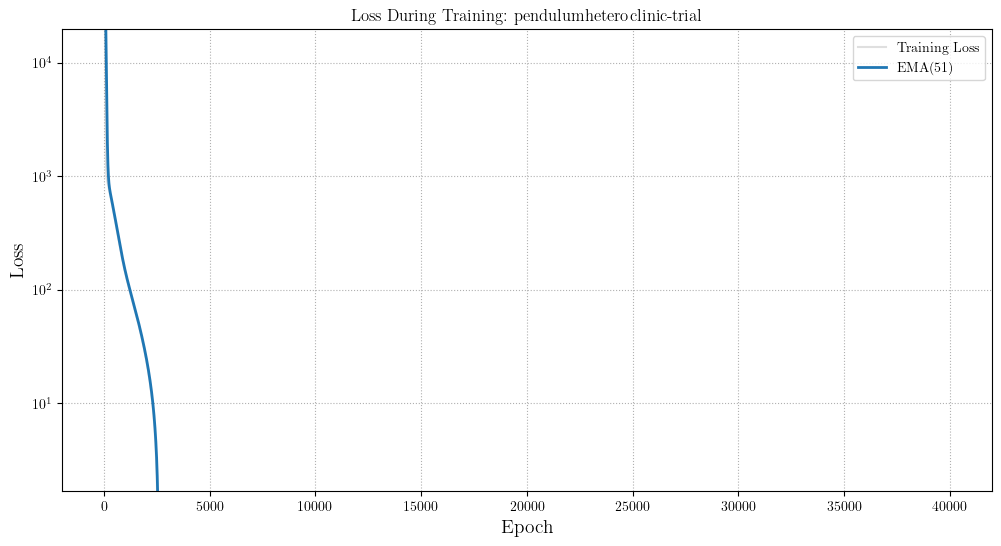

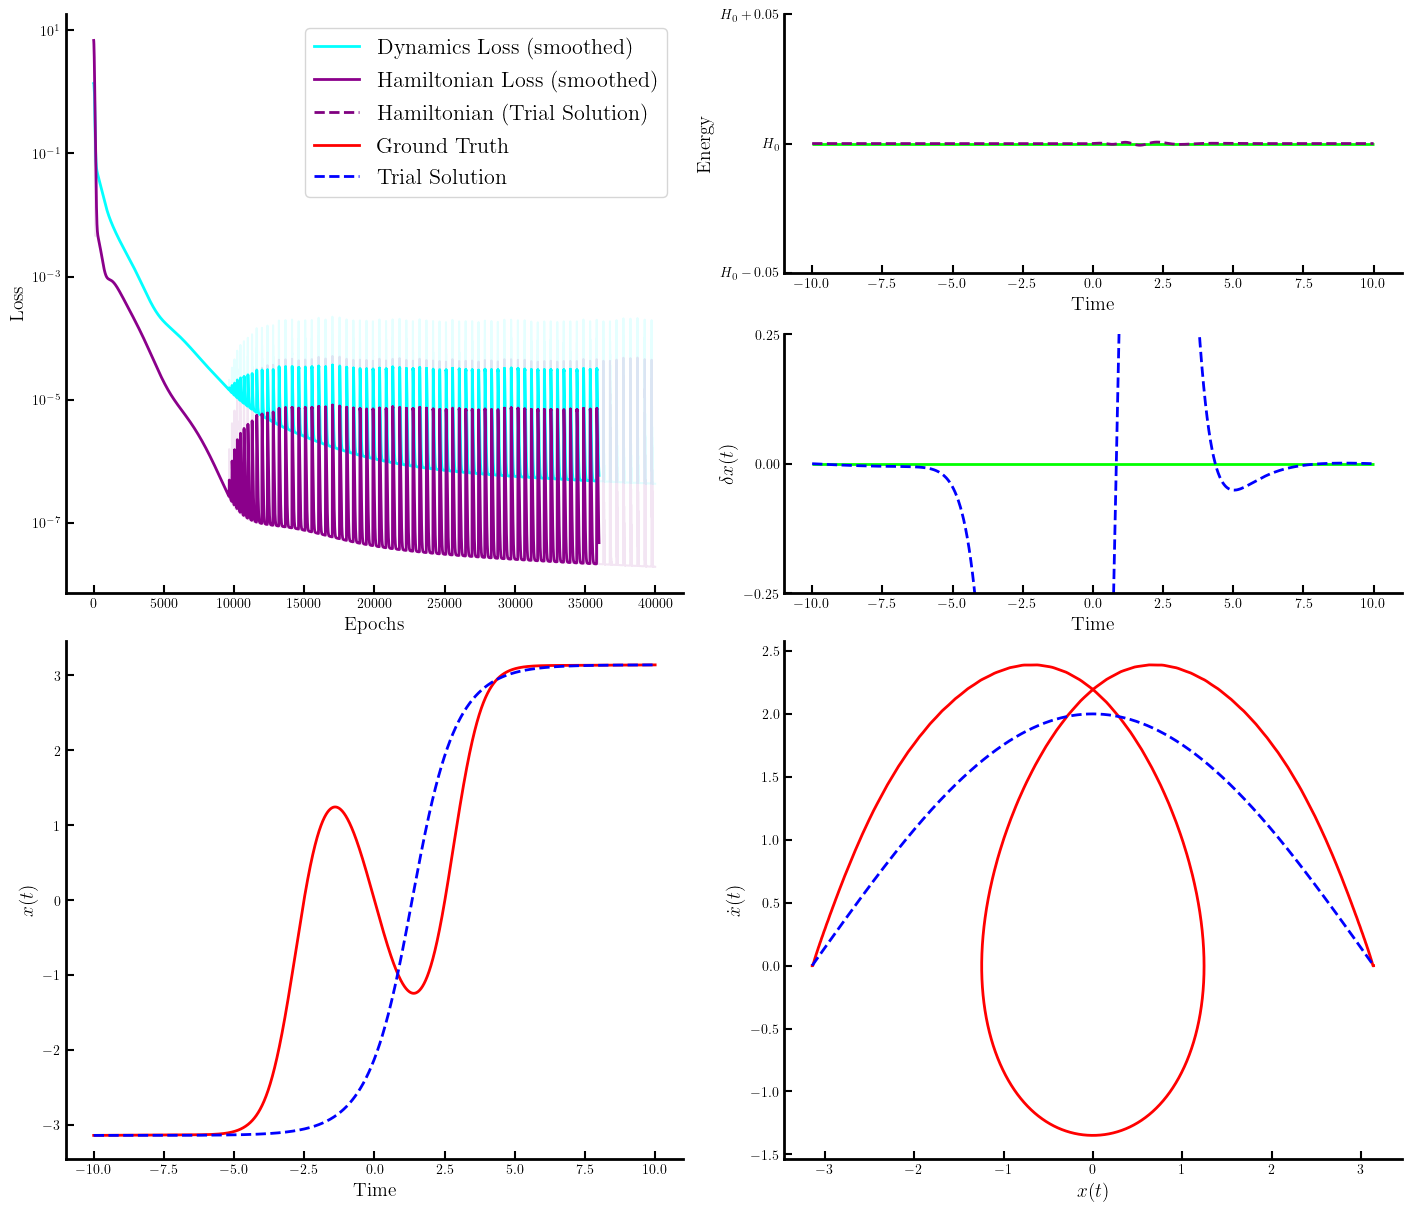

In [4]:
def main():
    lr_grid      = [1e-3, 1e-4]
    coeffs_grid = [(1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            boundary_type = "dirichlet"
            configuration = Configuration(
                seed=4235,
                features=[64, 64, 64, 64, 64],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs 40_000,
                steps=15_000,
            )

            equations = HeteroclinicPendulum(
                function="x",
                domain=(-10,10),
                initial_conditions={
                    "x": (-10, -np.pi),
                    "y": (10, np.pi),
                },
                coeffs = _coeffs,
                boundary_type=boundary_type
            )

            model = Model(
                name="pendulumheteroclinic-trial",
                configuration=configuration,
                system_equations=equations,
            )

            model.train()
            model.test3()

if __name__ == "__main__":
    main()